## IIIb. Classification model builds - GA-DA enhanced

- Use DEAP to develop GA searches for best features and hyperparameters for each augmented dataset from optimised CTGAN models
- DEAP provides an efficient API for running GA strategies - although GPUs are still required
- Uses the same grid space as that of DA enhanced models which used random search (RS)
- Use custom PR-AUC function for all model performance evaluations
- Baseline model is that using 'Training - Balanced' & best subset of features selected via RFE and hyperparameters found by random searcg in code IIIa
- Focus evaluation of models on the threshold invariant metrics of PR/ROC-AUC. The threshold-based metrics use the probability cut-off which balances specificity and sensitivity ('ss'). Exploratory analysis shows that a cut-off based on balancing precision and recall assigns most test samples to positive class giving poor results and the 0.5 cut-off is non-sensical given the priors. Do not know how Tsai et al (2022) and Shih et al (2023) derived their threshold cut-off but assume it is 0.5
- Check if probability scores are calibrated and if model performance (PR-AUC) is statistically different from that of other models

### Contents

1. Set up packages & drives
2. User-defined functions
3. GA function builds
4. Import & prepare data
5. Build optimal models for each data augmentation scenario using GA for feature & hyperparameter selection
6. Fitness scores by generation
7. Evaluation of models
8. Calibration checks
9. Permutation tests
10. Load all relevant files from model runs

### **1. Set up packages & drives**

In [ ]:
!pip install deap

In [4]:
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import argmax,sqrt
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
from sklearn.metrics import make_scorer,accuracy_score,precision_score,precision_recall_curve,recall_score,f1_score,confusion_matrix,auc,roc_curve,accuracy_score,roc_auc_score,average_precision_score,log_loss,brier_score_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,train_test_split,RandomizedSearchCV,cross_val_score
import seaborn as sns
import time
import random
from scipy.stats import randint,uniform
from sklearn.feature_selection import RFE
import pickle
from deap import base, creator, tools, algorithms
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Get access to Google Drive (run once per session)
drive.mount('/content/drive')

### **2. User-defined functions**

In [4]:
########## Data preparation #########

def data_prep(model_name,train,test):

  ##### Get data #####

  train_df=pd.read_pickle(train)
  test_df=pd.read_pickle(test)

  ##### Standardize data #####

  # Training

  # Get all numeric features for standardization
  features=train_df.drop(['disease1','type'],axis=1)
  # Standardize numeric features
  scaler=MinMaxScaler()
  scaler.fit(features)
  features_std=scaler.transform(features)
  # Combine the standardized features with the target feature
  features_std=pd.DataFrame(features_std, columns=features.columns)
  features_std['disease1']=train_df['disease1']
  train=features_std
  # Make target feature numeric
  train['disease1']=train['disease1'].astype('int64')

  # Test

  test_features=test_df.drop('disease1',axis=1)
  # Standardize numeric features
  test_features_std=scaler.transform(test_features)
  # Combine the scaled features with the target feature
  test_features_std=pd.DataFrame(test_features_std, columns=test_features.columns)
  test_features_std['disease1']=test_df['disease1']
  test=test_features_std
  # Make target feature numeric
  test['disease1']=test['disease1'].astype('int64')

  ##### Split features and labels for model build #####

  x_train=train.drop(['disease1'],axis=1)
  y_train=train['disease1']
  x_test=test.drop(['disease1'],axis=1)
  y_test=test['disease1']

  ##### Check datasets #####

  train_samples=x_train.shape[0]
  train_labels=y_train.shape[0]
  test_samples=x_test.shape[0]
  test_labels=y_test.shape[0]
  all_samples=train_samples+test_samples
  all_labels=train_labels+test_labels
  sizing_dic={model_name:{'train_samples':train_samples,
                          'train_labels':train_labels,
                          'test_samples':test_samples,
                          'test_labels':test_labels,
                          'all_samples':all_samples,
                          'all_labels':all_labels}}

  sizing_df=pd.DataFrame.from_dict(sizing_dic,orient='index')


  return(x_train,y_train,x_test,y_test,sizing_df)

########## Custom model evaluation function ##########

def pr_auc_eval(y_true,y_pred):
    precision,recall,_=precision_recall_curve(y_true, y_pred)
    pr_auc=auc(recall,precision)
    return pr_auc

########## Calculate F1-scores (array) from precision & recall arrays #########

def f1_scores_array(precision, recall):
    # Ensure the arrays are of same length
    assert len(precision)==len(recall), "Arrays must have same length"
    # Set up scores array with default value of 0
    f1_scores=np.zeros(len(precision))
    # Calculate score for each pair of precision & recall values
    for i in range(len(precision)):
        if precision[i]==0 and recall[i]==0:
            f1_scores[i]=0
        else:
            f1_scores[i]=2*(precision[i]*recall[i])/(precision[i]+recall[i])
    return f1_scores

########## Model evaluation ###########

def model_eval(model_name, y_test, y_pred, y_class, feat_names, feat_imp, valid_score, assign_method=None):

  ##### Consider alternative methods for determining optimal threshold cut-off #####

  # Balancing recall & precision - APPEARS TO CLASSIFY ALL CLASSES AS POSITIVE CLASS - DO NOT USE

  if assign_method=='pr':
    precision0, recall0, thresholds=precision_recall_curve(y_test,y_pred)
    f1_scores=f1_scores_array(precision0, recall0)
    # Get optimal threshold
    idx=np.argmax(f1_scores)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Balancing sensitivity & specificity

  elif assign_method=='ss':
    fpr0, tpr0, thresholds=roc_curve(y_test,y_pred)
    gmeans=np.sqrt(tpr0*(1-fpr0))
    idx=np.argmax(gmeans)
    y_class=(y_pred>=thresholds[idx]).astype(int)

  # Maximum probability score - default method when no argument included in function call
  else:
     y_class

  ##### Performance metrics on test data #####

  logloss=log_loss(y_test,y_pred)
  accuracy=accuracy_score(y_test,y_class)
  recall=recall_score(y_test,y_class)
  precision=precision_score(y_test,y_class)
  tn,fp,fn,tp=confusion_matrix(y_test,y_class).ravel()
  specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
  f1=f1_score(y_test,y_class)
  pr_auc=average_precision_score(y_test,y_pred)
  roc_auc=roc_auc_score(y_test,y_pred)
  fpr,tpr,_=roc_curve(y_test,y_pred)

  metrics_dic={model_name:{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':valid_score}}
  metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

  ##### Feature importance scores #####

  feat_imp_df=pd.DataFrame({'feature':feat_names,'importance':feat_imp})
  feat_imp_df=feat_imp_df.sort_values(by='importance',ascending=False)
  feat_imp_df[model_name]=round(feat_imp_df['importance'].rank(ascending=False),0)
  feat_imp_df.sort_values('feature',ascending=True,inplace=True)
  feat_imp_df.drop(columns=['importance'],axis=1,inplace=True)
  feat_imp_df=feat_imp_df.reset_index(drop=True)

  ##### PR & ROC curve data (threshold invariant) #####

  # PR curve
  precision1,recall1,thresholds=precision_recall_curve(y_test,y_pred)
  random_model=len(y_test[y_test==1])/len(y_test)
  pr_curve_dic={model_name:{'precision':precision1,
                            'recall':recall1,
                            'random_model':random_model,
                            'pr_auc':pr_auc}}
  #pr_curve_df=pd.DataFrame.from_dict(pr_curve_dic,orient='index')

  # ROC curve
  fpr,tpr,_=roc_curve(y_test,y_pred)
  roc_curve_dic={model_name:{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}
  #roc_curve_df=pd.DataFrame.from_dict(roc_curve_dic,orient='index')

  return metrics_df, feat_imp_df, pr_curve_dic, roc_curve_dic

########## Feature ranks heatmap ##########

def feat_heatmap(df, title, x, y, opt_flag=None):
  # Flag informs the function if the CTGAN was optimised or not

  # Sort data
  df1=df.sort_values(by=df.columns[0]).reset_index(drop=True)

  # Replace NaN with 99 (='not used by model')
  df2=df1.fillna(99)

  # Group the ranks for easier interpretation e.g. values 1, 2, 3, 4, 5 are set to 5

  def replace_values(value):

      replacement_values={ 1:5,   2:5,   3:5,   4:5,   5:5,
                          6:10,  7:10,  8:10,  9:10, 10:10,
                          11:15, 12:15, 13:15, 14:15, 15:15,
                          16:20, 17:20, 18:20, 19:20, 20:20,
                          21:25, 22:25, 23:25, 24:25, 25:25,
                          26:30, 27:30, 28:30, 29:30, 30:30,
                          31:35, 32:35, 33:35, 34:35, 35:35,
                          36:40,
                          99:99}

      return replacement_values.get(value,value)

  df3=df2.applymap(replace_values)

  # Reshape data for heatmap
  df4=pd.melt(df3, id_vars=['feature'], var_name='Model', value_name='Rank')

  # Specify order of models
  if opt_flag==1:
    custom_model_order=['_25_o','_50_o','_100_o','_250_o','_500_o','_1000_o']
  else:
    custom_model_order=['_bal','_25','_50','_100','_250','_500','_1000']

  # Convert 'Model' column to categorical with custom order
  df4['Model']=pd.Categorical(df4['Model'], categories=custom_model_order, ordered=True)

  # Sort the dataframe & pivot
  df5=df4.sort_values(by=['feature','Model'])
  df5.rename(columns={'feature':'Feature'}, inplace=True)

  heatmap_data=df5.pivot(index='Feature', columns='Model', values='Rank')

  # Plot heat map
  colors = sns.color_palette("viridis_r", as_cmap=True)
  heatmap = sns.heatmap(heatmap_data, cmap=colors, annot=True, fmt="g", cbar=False, ax=axes[x, y])
  heatmap.set_title(title)
  heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=9)
  heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=9)
  heatmap.set_xlabel(heatmap.get_xlabel(),fontsize=11)
  heatmap.set_ylabel(heatmap.get_ylabel(),fontsize=11)

  return

########## Plotting PR & ROC curves (version 1) ##########

def auc_curves2(# PR curve
                best_pr1,   best_pr2,
                # ROC curve
                best_roc1,  best_roc2,
                # title
                title,
                # Subplot positions - row=i, col0=j, col1=k
                i,j,k):

  ########## PR curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  pr_auc_best_feats=best_pr1['pr_auc']
  axes[i,j].plot(best_pr1['recall'],best_pr1['precision'],label=f'GA feats & default hypers - AUC={pr_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  pr_auc_best_feats=best_pr2['pr_auc']
  axes[i,j].plot(best_pr2['recall'],best_pr2['precision'],label=f'GA feats & GA hypers - AUC={pr_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,j].plot([0, 1],[best_pr1['random_model'],best_pr1['random_model']], linestyle='--',color='gray',label='Random model')

  axes[i,j].set_xlabel('Recall',fontsize=10)
  axes[i,j].tick_params(axis='x',labelsize=10)
  axes[i,j].set_ylabel('Precision',fontsize=10)
  axes[i,j].tick_params(axis='y',labelsize=10)
  axes[i,j].set_ylim(0.75,1.01)
  axes[i,j].set_title(title+' - PR curve',fontsize=11)
  axes[i,j].legend(loc='lower right',fontsize=7,frameon=False)

  ########## ROC curve ##########

  # Best subset of features
  # Non-optimised CTGAN
  roc_auc_best_feats=best_roc1['roc_auc']
  axes[i,k].plot(best_roc1['fpr'],best_roc1['tpr'],label=f'GA feats & default hypers - AUC={roc_auc_best_feats:.2f}',color='magenta')
  # Optimised CTGAN
  roc_auc_best_feats=best_roc2['roc_auc']
  axes[i,k].plot(best_roc2['fpr'],best_roc2['tpr'],label=f'GA feats & GA hypers - AUC={roc_auc_best_feats:.2f}',color='magenta',linestyle=':')

  # Random model (same for all augmentation scenarios)
  axes[i,k].plot([0, 1], [0, 1],linestyle='--', color='gray',label='Random model')


  axes[i,k].set_xlabel('False Positive Rate (FPR)',fontsize=10)
  axes[i,k].tick_params(axis='x',labelsize=10)
  axes[i,k].set_ylabel('True Positive Rate (TPR)',fontsize=10)
  axes[i,k].tick_params(axis='y',labelsize=10)
  axes[i,k].set_ylim(0.0,1.01)
  axes[i,k].set_title(title+' - ROC curve', fontsize=11)
  axes[i,k].legend(loc='lower right',fontsize=7,frameon=False)

  return

########## Plot reliability curves for each model's raw scores and calibrated scores ##########

def calibration_plot(pred_scores,
                     feats,
                     hypers,
                     x_train,
                     y_train,
                     x_test,
                     y_test,
                     method,
                     title,
                     pos1,
                     pos2):

  # Get reliability curve data
  prob_true, prob_pred=calibration_curve(y_test, pred_scores, n_bins=10)

  # Get calibrated pred scores - need to rebuild DA enhanced model
  clf=lgb.LGBMClassifier(**hypers, verbose=-1)
  clf.fit(x_train[feats], y_train)
  clf_cal=CalibratedClassifierCV(clf, method=method)
  clf_cal.fit(x_train[feats], y_train)
  pred_scores_cal=clf_cal.predict_proba(x_test[feats])[:, 1]

  # Create calibration reliability curve data
  prob_true_cal, prob_pred_cal=calibration_curve(y_test, pred_scores_cal, n_bins=10)

  # Calculate Brier scores
  brier_score=brier_score_loss(y_test,pred_scores)
  brier_score_cal=brier_score_loss(y_test,pred_scores_cal)

  # Plot calibration curve
  ax=axes[pos1,pos2]
  ax.plot(prob_pred, prob_true, marker='o', linestyle='-',color='magenta',label=f'Model scores (Brier={brier_score:.4f})')
  ax.plot(prob_pred_cal, prob_true_cal, marker='o', linestyle='-',color='cyan',label=f'Calibrated model scores (Brier={brier_score_cal:.4f})')
  ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')  # Perfectly calibrated line
  ax.set_xlabel('Mean predicted probability',fontsize=12)
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.set_ylabel('Proportion of actual positives',fontsize=12)
  ax.set_title(title,fontsize=16)
  ax.legend(frameon=False,fontsize=12)
  ax.grid(True,alpha=0.3)

  return pred_scores_cal

########## Permutation test for statistically significant models ##########

# The following significance_test() function code is that of Mostafa M. Amin and can be found at:
# https://mostafa-amin.com/post/permutation-significance-tests/#:~:text=A%20permutation%20test%20is%20a,the%20models%20is%20statistically%20significant.

# Function to calculate PR-AUC
def pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

def significance_test(metric_fn, y_true, y_pred_a, y_pred_b, tries=4096, random_state=41):
    assert y_true.shape[0] == y_pred_a.shape[0] == y_pred_b.shape[0]

    # Get initial test statistic
    metric_a = metric_fn(y_true, y_pred_a)
    metric_b = metric_fn(y_true, y_pred_b)
    benchmark = (metric_a - metric_b)

    if random_state is not None:
        # Fixing seed for reproducability
        np.random.seed(random_state)

    # Create the distribution of test statistics via the permutation runs
    samples = np.zeros(tries)
    for i in range(tries):
        # Create lookup to create two groups for shuffling
        msk = np.random.random(size=y_true.shape[0]) < 0.5
        y_pred_a_perm = y_pred_a.copy()
        y_pred_b_perm = y_pred_b.copy()
        y_pred_a_perm[msk] = y_pred_b[msk]
        y_pred_b_perm[msk] = y_pred_a[msk]
        samples[i]=(metric_fn(y_true, y_pred_a_perm) - metric_fn(y_true, y_pred_b_perm))

    # Calculate p-value
    pvalue = 1 - np.mean(benchmark > samples)

    return pvalue

### **3. GA function builds**

#### **3.1. Function to select best features using default hyperparameters**

In [5]:
def feat_sel_ga(x_train, y_train, tourn_num, pop_num, cross_prob, mut_prob, num_gens):

  start = time.time()

  # Create validation datasets
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.35, random_state=42)

  #################### Set up the DEAP toolbox with GA operators and fitness function ####################

  # Instantiate a fitness function which maximises fitness function ('1' for maximisation)
  creator.create("FitnessMax", base.Fitness, weights=(1.0,))

  # Instantiate an individual (chromosome) as a list with the fitness function defined above
  creator.create("Individual", list, fitness=creator.FitnessMax)

  # Declare size of the individual (=36 genes, one gene per feature)
  ind_size = x_train.shape[1]

  # Declare the toolbox container which will contain all required operators
  toolbox = base.Toolbox()

  # Register the required operators in the toolbox

  # Register a random number generator function in the toolbox to randomly generate a 1 or 0 in each gene which flags the presence of a feature
  toolbox.register("attrib_bin", random.randint, 0, 1)

  # Register the individuals in the toolbox and insert random 0s and 1s in their 36 genes
  # initRepeat initializes the individual
  toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attrib_bin, n=ind_size)

  # Register a population (based on individuals defined above) in the toolbox
  # initRepeat initializes the population
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Define fitness function which will be applied to each individual when called
  def evaluate(individual):

      # If all genes=0 then set fitness score to 0
      sum_features = np.sum(individual)
      if sum_features == 0:
          return 0.0

      # For the genes=1 create training & test dataframes containing selected features where gene=1 & calculate fitness score
      else:
          sum_features = np.sum(individual)
          new_train = []
          new_test = []
          for k in range(0, len(individual)):
              if individual[k] == 1:
                  new_train.append(x_train.iloc[:, k])
                  new_test.append(x_valid.iloc[:, k]) ##### SHOULD BE VALIDATION #####
          x_train_a = np.transpose(np.array(new_train))
          x_valid_a = np.transpose(np.array(new_test))
          np.nan_to_num(x_train_a, copy=False)
          np.nan_to_num(y_train, copy=False)
          np.nan_to_num(x_valid_a, copy=False)
          np.nan_to_num(y_valid, copy=False)

          # Train a LGBM classifier on feature subset
          model=lgb.LGBMClassifier()
          model.set_params(verbose=-1)
          clf=model.fit(x_train_a, y_train)

          # Calculate fitness score for each individual in test data
          y_pred=clf.predict_proba(x_valid_a)[:, 1]
          precision, recall,_=precision_recall_curve(y_valid, y_pred)
          pr_auc=auc(recall,precision)

          return (pr_auc,)

  # Register GA operators & fitness function in the DEAP toolbox

  # Selection method - tournament (size=3)
  toolbox.register("select", tools.selTournament, tournsize=tourn_num)
  # Crossover method - two point
  toolbox.register("mate", tools.cxTwoPoint)
  # Mutation - probability of any gene being flipped
  toolbox.register("mutate", tools.mutFlipBit, indpb=0.01)
  # Fitness function defined above
  toolbox.register("evaluate", evaluate)

  #################### Run GA for required number of generations ####################

  # Set initial population size
  pop = toolbox.population(n=pop_num)

  # Save fittest individual from each generation
  hof = tools.HallOfFame(1)

  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("avg", np.mean)
  stats.register("max", np.max)

  # Run GA algorithm with parameters:
  # pop = population size
  # toolbox = GA operators & fitness function
  # cxpb = probability of crossover of two individuals
  # mutpb = probability of mutating an individual
  # ngen = number of generations
  pop, log = algorithms.eaSimple(pop,
                                 toolbox,
                                 cxpb=cross_prob,
                                 mutpb=mut_prob,
                                 ngen=num_gens,
                                 halloffame=hof,
                                 stats=stats)

  # Get the best individual
  best = hof.items[0]

  # Get its fitness value
  best_fit_score=best.fitness.values[0]

  # Get its number of features
  best_feats_len=sum(best)

  # Get the names of its feature
  best_feats=[]
  for k in range(0, 36):
    # Get feature if gene=1
    if best[k]==1:
        best_feats.append(x_train.columns[k])

  end=time.time()
  print('run time:', round((end-start)/60,0))

  return log, best_fit_score, best_feats_len, best_feats

#### **3.2. Function to select best hyperparameters with best features already selected via GA**

In [6]:
def hyp_sel_ga(x_train, y_train, feats, pop_num, cross_prob, mut_prob, num_gens):

  start = time.time()

  # Create validation datasets
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.35, random_state=42)

  #################### Set up the DEAP toolbox with GA operators and fitness function ####################

  # Instantiate a fitness function which maximises fitness function ('1' for maximisation)
  creator.create("FitnessMax", base.Fitness, weights=(1.0,))

  # Instantiate an individual (chromosome) as a list with the fitness function defined above
  creator.create("Individual", list, fitness=creator.FitnessMax)

  # Declare the toolbox container which will contain all required operators
  toolbox = base.Toolbox()

  # Register the distribution of hyperparameter values for each gene in the toolbox

  # Define search grid - same as that used for DA enhanced models & its randomised search
  # Remainder of hyperparameters are assumed as 'default values'
  # Presented in order as per LGBMClassifier() documentation
  lower_num_leaves,         upper_num_leaves          = 5,      60
  lower_max_depth,          upper_max_depth           = 1,      15
  lower_learning_rate,      upper_learning_rate       = 0.01,   0.15
  lower_n_estimators,       upper_n_estimators        = 80,     120
  lower_subsample_for_bin,  upper_subsample_for_bin   = 1000,   6500
  lower_min_split_gain,     upper_min_split_gain      = 0.001,  0.02
  lower_min_child_weight,   upper_min_child_weight    = 0.001,  0.005
  lower_min_child_samples,  upper_min_child_samples   = 5,      60
  lower_subsample,          upper_subsample           = 0.7,    1.0
  lower_subsample_freq,     upper_subsample_freq      = 0,      3
  lower_colsample_bytree,   upper_colsample_bytree    = 0.8,    1.0
  lower_reg_alpha,          upper_reg_alpha           = 0,      0.05
  lower_reg_lambda,         upper_reg_lambda          = 0,      0.05

  toolbox.register("attr_num_leaves",         random.randint, lower_num_leaves,         upper_num_leaves)
  toolbox.register("attr_max_depth",          random.randint, lower_max_depth,          upper_max_depth)
  toolbox.register("attr_learning_rate",      random.uniform, lower_learning_rate,      upper_learning_rate)
  toolbox.register("attr_n_estimators",       random.randint, lower_n_estimators,       upper_n_estimators)
  toolbox.register("attr_subsample_for_bin",  random.randint, lower_subsample_for_bin,  upper_subsample_for_bin)
  toolbox.register("attr_min_split_gain",     random.uniform, lower_min_split_gain,     upper_min_split_gain)
  toolbox.register("attr_min_child_weight",   random.uniform, lower_min_child_weight,   upper_min_child_weight)
  toolbox.register("attr_min_child_samples",  random.randint, lower_min_child_samples,  upper_min_child_samples)
  toolbox.register("attr_subsample",          random.uniform, lower_subsample,          upper_subsample)
  toolbox.register("attr_subsample_freq",     random.randint, lower_subsample_freq,     upper_subsample_freq)
  toolbox.register("attr_colsample_bytree",   random.uniform, lower_colsample_bytree,   upper_colsample_bytree)
  toolbox.register("attr_reg_alpha",          random.uniform, lower_reg_alpha,          upper_reg_alpha)
  toolbox.register("attr_reg_lambda",         random.uniform, lower_reg_lambda,         upper_reg_lambda)

  # Register the individuals in the toolbox and insert random values of hyperparameters for each gene
  N_CYCLES = 1
  toolbox.register("individual",
                  tools.initCycle,
                  creator.Individual,
                  (toolbox.attr_num_leaves,
                    toolbox.attr_max_depth,
                    toolbox.attr_learning_rate,
                    toolbox.attr_n_estimators,
                    toolbox.attr_subsample_for_bin,
                    toolbox.attr_min_split_gain,
                    toolbox.attr_min_child_weight,
                    toolbox.attr_min_child_samples,
                    toolbox.attr_subsample,
                    toolbox.attr_subsample_freq,
                    toolbox.attr_colsample_bytree,
                    toolbox.attr_reg_alpha,
                    toolbox.attr_reg_lambda),
                  n=N_CYCLES)

  # Register a population (based on individuals defined above) in the toolbox
  # initRepeat initializes the population
  toolbox.register("population", tools.initRepeat, list, toolbox.individual)

  # Create mutation function which randomly selects a gene & randomly generates a new value for it
  def mutate(individual):

      # Select which gene to mutate
      gene = random.randint(0,12)

      # Undertake mutation of selected gene
      if gene == 0:
        individual[0] == random.randint(lower_num_leaves, upper_num_leaves)
      elif gene == 1:
        individual[1] == random.randint(lower_max_depth, upper_max_depth)
      elif gene == 2:
        individual[2] == random.uniform(lower_learning_rate, upper_learning_rate)
      elif gene == 3:
        individual[3] == random.randint(lower_n_estimators, upper_n_estimators)
      elif gene == 4:
        individual[4] == random.randint(lower_subsample_for_bin, upper_subsample_for_bin)
      elif gene == 5:
        individual[5] == random.uniform(lower_min_split_gain, upper_min_split_gain)
      elif gene == 6:
        individual[6] == random.uniform(lower_min_child_weight, upper_min_child_weight)
      elif gene == 7:
        individual[7] == random.randint(lower_min_child_samples, upper_min_child_samples)
      elif gene == 8:
        individual[8] == random.uniform(lower_subsample, upper_subsample)
      elif gene == 9:
        individual[9] == random.randint(lower_subsample_freq, upper_subsample_freq)
      elif gene == 10:
        individual[10] == random.uniform(lower_colsample_bytree, upper_colsample_bytree)
      elif gene == 11:
        individual[11] == random.uniform(lower_reg_alpha, upper_reg_alpha)
      elif gene == 12:
        individual[12] == random.uniform(lower_reg_lambda, upper_reg_lambda)

      return individual,

  # Create fitness function which calculates PR-AUC for the hyperparameters in an individual chromosome
  def evaluate(individual):

      # Extract the hyperparameter values from the individual chromosome
      num_leaves = individual[0]
      max_depth = individual[1]
      learning_rate = individual[2]
      n_estimators = individual[3]
      subsample_for_bin = individual[4]
      min_split_gain = individual[5]
      min_child_weight = individual[6]
      min_child_samples = individual[7]
      subsample = individual[8]
      subsample_freq = individual[9]
      colsample_bytree = individual[10]
      reg_alpha = individual[11]
      reg_lambda = individual[12]

      model=lgb.LGBMClassifier(num_leaves=num_leaves,
                               max_depth=max_depth,
                               learning_rate=learning_rate,
                               n_estimators=n_estimators,
                               subsample_for_bin=subsample_for_bin,
                               min_split_gain=min_split_gain,
                               min_child_weight=min_child_weight,
                               min_child_samples=min_child_samples,
                               subsample=subsample,
                               subsample_freq=subsample_freq,
                               colsample_bytree=colsample_bytree,
                               reg_alpha=reg_alpha,
                               reg_lambda=reg_lambda)

      model.set_params(verbose=-1)
      clf=model.fit(x_train[feats], y_train)

      # Get prediction probabilities & calculate fitness (PR-AUC) for individual chromosome in test samples
      y_pred=clf.predict_proba(x_valid[feats])[:, 1]
      precision, recall,_=precision_recall_curve(y_valid, y_pred)
      pr_auc=auc(recall,precision)

      return pr_auc,

  # Register GA operators and fitness function with toolbox
  toolbox.register("select", tools.selTournament, tournsize=3)
  toolbox.register("mate", tools.cxOnePoint)
  toolbox.register("mutate",mutate)
  toolbox.register("evaluate", evaluate)

  #################### Run the GA algorithm with selected GA hyperparameters ####################

  # Set GA hyperparameters
  population_size       = pop_num
  crossover_probability = cross_prob
  mutation_probability  = mut_prob
  number_of_generations = num_gens

  # Set initial population size
  pop = toolbox.population(n=population_size)

  # Collect best performing individual per generation
  hof = tools.HallOfFame(1)

  # Set up fitness function statistics collection
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  # Run the algorithm
  pop, log = algorithms.eaSimple(pop,
                                 toolbox,
                                 cxpb=crossover_probability,
                                 stats = stats,
                                 mutpb = mutation_probability,
                                 ngen=number_of_generations,
                                 halloffame=hof,
                                 verbose=True)

  # Get the best individual
  best = hof.items[0]

  # Get its fitness value
  best_fit_score=best.fitness.values[0]

  # Get best hyperparameters
  best_hypers = hof[0]

  # Get names of best hyperparameters
  hyper_names=['num_leaves','max_depth','learning_rate','n_estimators','subsample_for_bin','min_split_gain','min_child_weight','min_child_samples','subsample','subsample_freq','colsample_bytree','reg_alpha','reg_lambda']
  hypers=dict(zip(hyper_names, best_hypers))

  end=time.time()
  print('Run time in minutes:', round((end-start)/60,0))

  return log, best_fit_score, hypers

#### **3.3. Function to build model with features & hyperparameters optimised by GA & evaluate performance**

In [7]:
def model_eval_ga(hypers, x_train, y_train, x_test, y_test, feats, dataset_name):

  # Instantiate classifier with default hyperparameters
  model=lgb.LGBMClassifier(**hypers)
  model.set_params(verbose=-1)

  # Use cross-validation to check model performance
  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_scores=cross_val_score(model, x_train[feats], y_train, cv=cv, scoring=make_scorer(pr_auc_eval,greater_is_better=True,needs_proba=True))
  #print("Mean PR-AUC:", cv_scores.mean())

  # Train model on full training data
  clf=model.fit(x_train[feats], y_train)

  # Get prediction probabilities & class assignments (maximum probability scores) for test data
  y_pred=clf.predict_proba(x_test[feats])[:, 1]
  y_class=clf.predict(x_test[feats])

  # Get feature importance scores (based on gain & not split)
  feat_names=x_train[feats].columns.tolist()
  feat_imp=clf.booster_.feature_importance(importance_type='gain')

  # Evaluate
  metrics, feat_imp, pr_curve_dic, roc_curve_dic = model_eval(dataset_name, y_test, y_pred, y_class, feat_names, feat_imp, cv_scores.mean(), 'ss')

  return metrics, feat_imp, pr_curve_dic, roc_curve_dic

#### **3.4. Function to plot fitness statistics per GA generation**

In [8]:
def fit_gen_plot(log, num_gens, title1, title2, best_fit_score, best_ind, i, j):
# Note that x_ticks must be a multiple of 5

  gen  = log.select("gen")
  max  = log.select("max")
  mean = log.select("avg")
  min  = log.select("min")
  evolution = pd.DataFrame({'Generation': gen,
                            'Maximum'   : max,
                            'Mean'      : mean,
                            'Minimum'   : min})
  axes[i,j].set_title(title1, fontsize=11)
  axes[i,j].plot(evolution['Generation'], evolution['Minimum'], 'b', color = 'cyan', label = 'Min')
  axes[i,j].plot(evolution['Generation'], evolution['Mean'],    'b', color = 'magenta', label = 'Average')
  axes[i,j].plot(evolution['Generation'], evolution['Maximum'], 'b', color = 'blue', label = 'Max')
  axes[i,j].legend(loc='lower right', frameon=False)
  axes[i,j].set_ylabel('Precision-recall AUC')
  axes[i,j].set_xlabel('Generation')
  #plt.xticks([0,5,10,15,20,25])
  x_ticks=list(range(0, num_gens+1, 1))
  axes[i,j].set_xticks(x_ticks)

  print(title2+' - best individual fitness score:',best_fit_score)
  print(title2+' - best individual:', best_ind)
  print()

  return

### **4. Import & prepare data**

- Imports training dataset and test datasets
- Standardize training & transform test

In [9]:
# Baseline dataset (balanced using CTGAN)
x_train_bal_o,  y_train_bal_o,  x_test_bal_o,  y_test_bal_o,  sizing_bal_o  = data_prep('_bal',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_bal.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

# Dataset augmented using optimised CTGAN
x_train_25_o,   y_train_25_o,   x_test_25_o,   y_test_25_o,   sizing_25_o   = data_prep('_25_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_25.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_50_o,   y_train_50_o,   x_test_50_o,   y_test_50_o,   sizing_50_o   = data_prep('_50_o',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_50.pkl',   '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_100_o,  y_train_100_o,  x_test_100_o,  y_test_100_o,  sizing_100_o  = data_prep('_100_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_100.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_250_o,  y_train_250_o,  x_test_250_o,  y_test_250_o,  sizing_250_o  = data_prep('_250_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_250.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_500_o,  y_train_500_o,  x_test_500_o,  y_test_500_o,  sizing_500_o  = data_prep('_500_o',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_500.pkl',  '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')
x_train_1000_o, y_train_1000_o, x_test_1000_o, y_test_1000_o, sizing_1000_o = data_prep('_1000_o', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/aug_1000.pkl', '/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/df_test_imp_t_ctgan.pkl')

Check data set sizes

In [10]:
sizing_all=pd.concat([sizing_bal_o,sizing_25_o,sizing_50_o,sizing_100_o,sizing_250_o,sizing_500_o,sizing_1000_o],ignore_index=False)
sizing_all

,train_samples,train_labels,test_samples,test_labels,all_samples,all_labels
_bal,770,770,258,258,1028,1028
_25_o,950,950,258,258,1208,1208
_50_o,1140,1140,258,258,1398,1398
_100_o,1520,1520,258,258,1778,1778
_250_o,1900,1900,258,258,2158,2158
_500_o,3800,3800,258,258,4058,4058
_1000_o,7600,7600,258,258,7858,7858


### **5. Get optimal models for each data augmentation scenario using GA for feature & hyperparameter selection**

Build and evaluate models:
- GA feats & default hypers
- GA feats & GA hypers

Note: Baseline model is already built in code IIIa

In [ ]:
# Get values of default hyperparameters of LGBM
default_model = lgb.LGBMClassifier()
default_hypers = default_model.get_params()

In [ ]:
# _25

# Get features using GA & evaluate
log_f_25_o, fit_score_f_25_o, feats_len_f_25_o, feats_f_25_o = feat_sel_ga(x_train_25_o, y_train_25_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_25_o, feat_imp_f_25_o, pr_curve_dic_f_25_o, roc_curve_dic_f_25_o = model_eval_ga(default_hypers, x_train_25_o, y_train_25_o, feats=feats_f_25_o, dataset_name='_25_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_25_o, best_fit_score_fh_25_o, best_hyper_fh_25_o = hyp_sel_ga(x_train_25_o, y_train_25_o, feats_f_25_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_25_o, feat_imp_fh_25_o, pr_curve_dic_fh_25_o, roc_curve_dic_fh_25_o = model_eval_ga(best_hyper_fh_25_o, x_train_25_o, y_train_25_o, feats=feats_f_25_o, dataset_name='_25_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_25_o', 'wb') as file:
    pickle.dump(log_f_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25_o', 'wb') as file:
    pickle.dump(feats_f_25_o, file)
metrics_f_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_25_o.pkl')
feat_imp_f_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_25_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_25_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_25_o', 'wb') as file:
    pickle.dump(fit_score_f_25_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_25_o', 'wb') as file:
    pickle.dump(log_fh_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25_o', 'wb') as file:
    pickle.dump(best_hyper_fh_25_o, file)
metrics_fh_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o.pkl')
feat_imp_fh_25_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_25_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_25_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_25_o, file)

In [ ]:
# _50

# Get features using GA & evaluate
log_f_50_o, fit_score_f_50_o, feats_len_f_50_o, feats_f_50_o = feat_sel_ga(x_train_50_o, y_train_50_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_50_o, feat_imp_f_50_o, pr_curve_dic_f_50_o, roc_curve_dic_f_50_o = model_eval_ga(default_hypers, x_train_50_o, y_train_50_o, feats=feats_f_50_o, dataset_name='_50_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_50_o, best_fit_score_fh_50_o, best_hyper_fh_50_o = hyp_sel_ga(x_train_50_o, y_train_50_o, feats_f_50_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_50_o, feat_imp_fh_50_o, pr_curve_dic_fh_50_o, roc_curve_dic_fh_50_o = model_eval_ga(best_hyper_fh_50_o, x_train_50_o, y_train_50_o, feats=feats_f_50_o, dataset_name='_50_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_50_o', 'wb') as file:
    pickle.dump(log_f_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o', 'wb') as file:
    pickle.dump(feats_f_50_o, file)
metrics_f_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_50_o.pkl')
feat_imp_f_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_50_o', 'wb') as file:
    pickle.dump(fit_score_f_50_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_50_o', 'wb') as file:
    pickle.dump(log_fh_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o', 'wb') as file:
    pickle.dump(best_hyper_fh_50_o, file)
metrics_fh_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o.pkl')
feat_imp_fh_50_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_50_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_50_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_50_o, file)

In [ ]:
# _100

# Get features using GA & evaluate
log_f_100_o, fit_score_f_100_o, feats_len_f_100_o, feats_f_100_o = feat_sel_ga(x_train_100_o, y_train_100_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_100_o, feat_imp_f_100_o, pr_curve_dic_f_100_o, roc_curve_dic_f_100_o = model_eval_ga(default_hypers, x_train_100_o, y_train_100_o, feats=feats_f_100_o, dataset_name='_100_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_100_o, best_fit_score_fh_100_o, best_hyper_fh_100_o = hyp_sel_ga(x_train_100_o, y_train_100_o, feats_f_100_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_100_o, feat_imp_fh_100_o, pr_curve_dic_fh_100_o, roc_curve_dic_fh_100_o = model_eval_ga(best_hyper_fh_100_o, x_train_100_o, y_train_100_o, feats=feats_f_100_o, dataset_name='_100_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_100_o', 'wb') as file:
    pickle.dump(log_f_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100_o', 'wb') as file:
    pickle.dump(feats_f_100_o, file)
metrics_f_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_100_o.pkl')
feat_imp_f_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_100_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_100_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_100_o', 'wb') as file:
    pickle.dump(fit_score_f_100_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_100_o', 'wb') as file:
    pickle.dump(log_fh_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100_o', 'wb') as file:
    pickle.dump(best_hyper_fh_100_o, file)
metrics_fh_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_100_o.pkl')
feat_imp_fh_100_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_100_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_100_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_100_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_100_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_100_o, file)

In [ ]:
# _250

# Get features using GA & evaluate
log_f_250_o, fit_score_f_250_o, feats_len_f_250_o, feats_f_250_o = feat_sel_ga(x_train_250_o, y_train_250_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_250_o, feat_imp_f_250_o, pr_curve_dic_f_250_o, roc_curve_dic_f_250_o = model_eval_ga(default_hypers, x_train_250_o, y_train_250_o, feats=feats_f_250_o, dataset_name='_250_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_250_o, best_fit_score_fh_250_o, best_hyper_fh_250_o = hyp_sel_ga(x_train_250_o, y_train_250_o, feats_f_250_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_250_o, feat_imp_fh_250_o, pr_curve_dic_fh_250_o, roc_curve_dic_fh_250_o = model_eval_ga(best_hyper_fh_250_o, x_train_250_o, y_train_250_o, feats=feats_f_250_o, dataset_name='_250_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_250_o', 'wb') as file:
    pickle.dump(log_f_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250_o', 'wb') as file:
    pickle.dump(feats_f_250_o, file)
metrics_f_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_250_o.pkl')
feat_imp_f_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_250_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_250_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_250_o', 'wb') as file:
    pickle.dump(fit_score_f_250_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_250_o', 'wb') as file:
    pickle.dump(log_fh_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250_o', 'wb') as file:
    pickle.dump(best_hyper_fh_250_o, file)
metrics_fh_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o.pkl')
feat_imp_fh_250_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_250_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_250_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_250_o, file)

In [ ]:
# _500

# Get features using GA & evaluate
log_f_500_o, fit_score_f_500_o, feats_len_f_500_o, feats_f_500_o = feat_sel_ga(x_train_500_o, y_train_500_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_500_o, feat_imp_f_500_o, pr_curve_dic_f_500_o, roc_curve_dic_f_500_o= model_eval_ga(default_hypers, x_train_500_o, y_train_500_o, feats=feats_f_500_o, dataset_name='_500_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_500_o, best_fit_score_fh_500_o, best_hyper_fh_500_o = hyp_sel_ga(x_train_500_o, y_train_500_o, feats_f_500_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_500_o, feat_imp_fh_500_o, pr_curve_dic_fh_500_o, roc_curve_dic_fh_500_o = model_eval_ga(best_hyper_fh_500_o, x_train_500_o, y_train_500_o, feats=feats_f_500_o, dataset_name='_500_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_500_o', 'wb') as file:
    pickle.dump(log_f_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500_o', 'wb') as file:
    pickle.dump(feats_f_500_o, file)
metrics_f_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_500_o.pkl')
feat_imp_f_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_500_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_500_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_500_o', 'wb') as file:
    pickle.dump(fit_score_f_500_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_500_o', 'wb') as file:
    pickle.dump(log_fh_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500_o', 'wb') as file:
    pickle.dump(best_hyper_fh_500_o, file)
metrics_fh_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_500_o.pkl')
feat_imp_fh_500_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_500_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_500_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_500_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_500_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_500_o, file)

In [ ]:
# _1000

# Get features using GA & evaluate
log_f_1000_o, fit_score_f_1000_o, feats_len_f_1000_o, feats_f_1000_o = feat_sel_ga(x_train_1000_o, y_train_1000_o, tourn_num=3, pop_num=150, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_f_1000_o, feat_imp_f_1000_o, pr_curve_dic_f_1000_o, roc_curve_dic_f_1000_o = model_eval_ga(default_hypers, x_train_1000_o, y_train_1000_o, feats=feats_f_1000_o, dataset_name='_1000_o')
# Get hyperparameters using GA & best features found previously & evaluate
log_fh_1000_o, best_fit_score_fh_1000_o, best_hyper_fh_1000_o = hyp_sel_ga(x_train_1000_o, y_train_1000_o, feats_f_1000_o, pop_num=300, cross_prob=0.7, mut_prob=0.04, num_gens=20)
metrics_fh_1000_o, feat_imp_fh_1000_o, pr_curve_dic_fh_1000_o, roc_curve_dic_fh_1000_o = model_eval_ga(best_hyper_fh_1000_o, x_train_1000_o, y_train_1000_o, feats=feats_f_1000_o, dataset_name='_1000_o')

# Save

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_1000_o', 'wb') as file:
    pickle.dump(log_f_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000_o', 'wb') as file:
    pickle.dump(feats_f_1000_o, file)
metrics_f_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_1000_o.pkl')
feat_imp_f_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000_o', 'wb') as file:
    pickle.dump(pr_curve_dic_f_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000_o', 'wb') as file:
    pickle.dump(roc_curve_dic_f_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_1000_o', 'wb') as file:
    pickle.dump(fit_score_f_1000_o, file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_1000_o', 'wb') as file:
    pickle.dump(log_fh_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000_o', 'wb') as file:
    pickle.dump(best_hyper_fh_1000_o, file)
metrics_fh_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_1000_o.pkl')
feat_imp_fh_1000_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000_o', 'wb') as file:
    pickle.dump(pr_curve_dic_fh_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000_o', 'wb') as file:
    pickle.dump(roc_curve_dic_fh_1000_o, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_1000_o', 'wb') as file:
    pickle.dump(best_fit_score_fh_1000_o, file)

### **6. Fitness scores by generation**

#### 6.1. GA feats & default hyperparameters

+25% - best individual fitness score: 0.9436060876667064
+25% - best individual: ['albumin', 'ast_got', 'calcium', 'direct_bilirubin', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_cholesterol', 'urine_bilirubin', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking']

+50% - best individual fitness score: 0.941898058606699
+50% - best individual: ['bun', 'calcium', 'urine_occult_blood', 'ph', 'potassium', 'sodium', 'specific_gravity', 'total_cholesterol', 'uric_acid', 'urine_glucose', 'urine_ketone', 'urobilinogen', 'age', 'gender', 'hyper1en1ion', 'diabe1es', 'smoking']

+100% - best individual fitness score: 0.9452715532499922
+100% - best individual: ['albumin', 'alk', 'bun', 'calcium', 'nitrite', 'sodium', 'specific_gravity', 'total_cholesterol', 'uric_acid', 'urine_ketone', 'age', 'gender', 'smoking', 'drinking', 'bee1lenu1']

+250% - best individual fitness score: 0.9350453494177615
+250% - best individual: ['albumin', 'alk', 'ast_got',

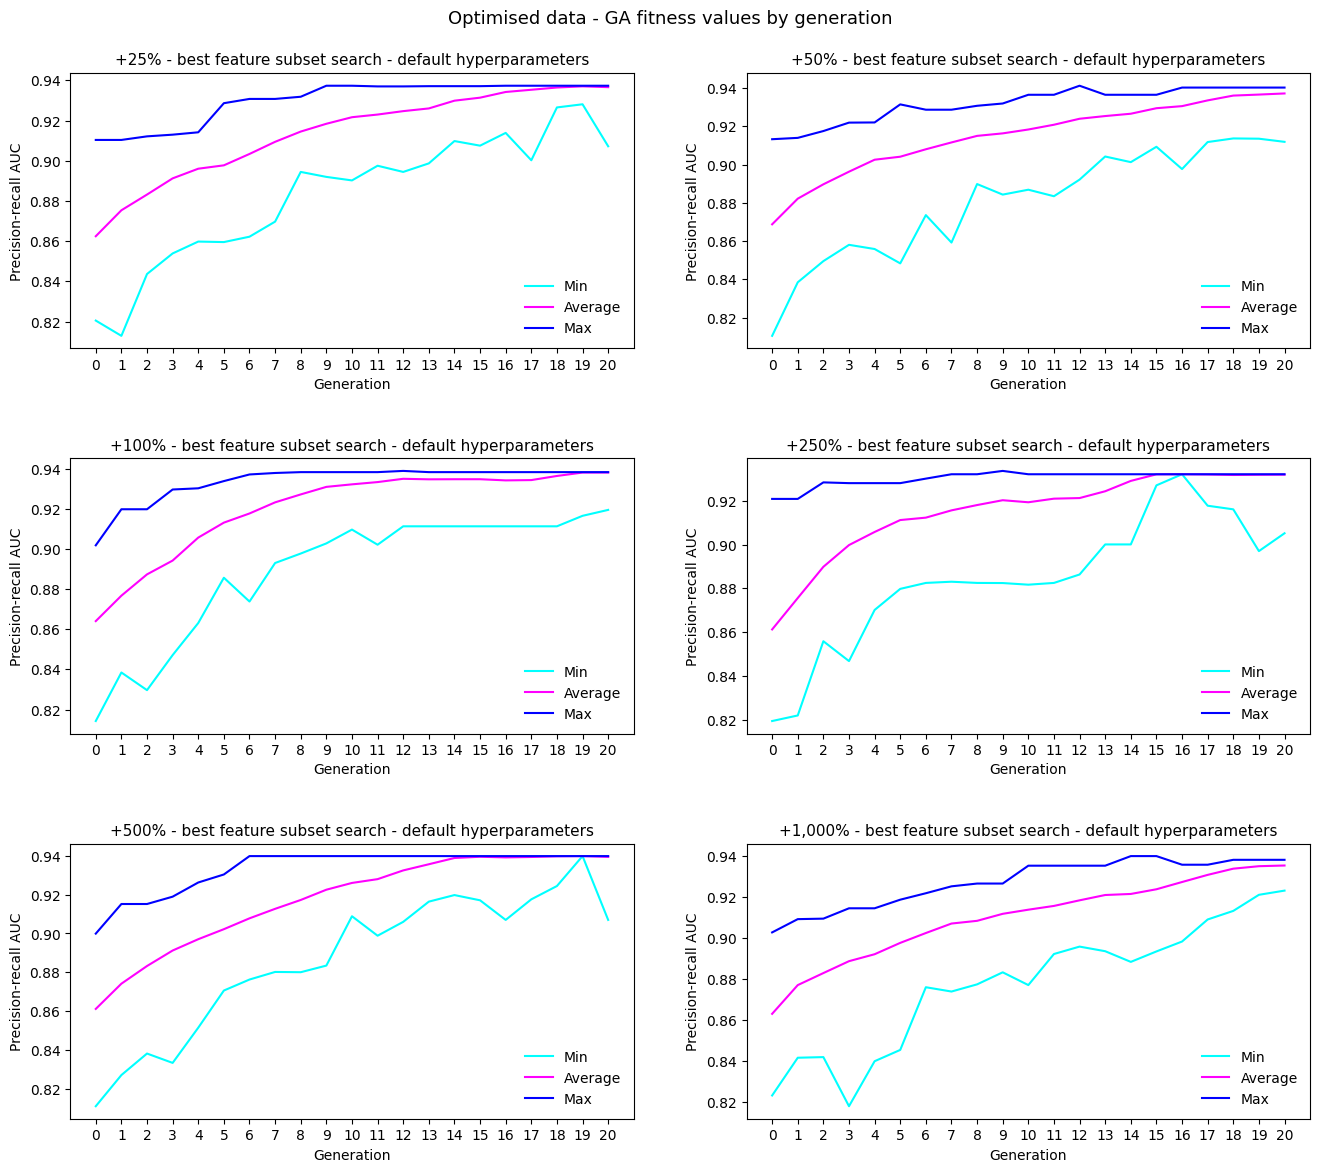

In [ ]:
fig, axes=plt.subplots(3,2,figsize=(16,12.75),gridspec_kw={'hspace': 0.4}) # width by height

#axes[3, 1].set_visible(False)

fit_gen_plot(log_f_25,    20, '+25% - best feature subset search - default hyperparameters',     '+25%',        fit_score_f_25_o,   feats_f_25_o,   0, 0)
fit_gen_plot(log_f_50,    20, '+50% - best feature subset search - default hyperparameters',     '+50%',        fit_score_f_50_o,   feats_f_50_o,   0, 1)
fit_gen_plot(log_f_100,   20, '+100% - best feature subset search - default hyperparameters',    '+100%',       fit_score_f_100_o,  feats_f_100_o,  1, 0)
fit_gen_plot(log_f_250,   20, '+250% - best feature subset search - default hyperparameters',    '+250%',       fit_score_f_250_o,  feats_f_250_o,  1, 1)
fit_gen_plot(log_f_500,   20, '+500% - best feature subset search - default hyperparameters',    '+500%',       fit_score_f_500_o,  feats_f_500_o,  2, 0)
fit_gen_plot(log_f_1000,  20, '+1,000% - best feature subset search - default hyperparameters',  '+1,000%',     fit_score_f_1000_o, feats_f_1000_o, 2, 1)

fig.suptitle('Optimised data - GA fitness values by generation', fontsize=13)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

#### 6.2. GA feats & GA hyperparameters

+25% - best individual fitness score: 0.9453341075576832
+25% - best individual: {'num_leaves': 33, 'max_depth': 5, 'learning_rate': 0.11773924722701844, 'n_estimators': 95, 'subsample_for_bin': 2378, 'min_split_gain': 0.013350682590829305, 'min_child_weight': 0.0033856060208060238, 'min_child_samples': 9, 'subsample': 0.7873527510393454, 'subsample_freq': 0, 'colsample_bytree': 0.9172200770224017, 'reg_alpha': 0.0013875808866667173, 'reg_lambda': 0.04424539844918825}

+50% - best individual fitness score: 0.947915477503964
+50% - best individual: {'num_leaves': 33, 'max_depth': 8, 'learning_rate': 0.10865659691009796, 'n_estimators': 116, 'subsample_for_bin': 3326, 'min_split_gain': 0.007765231135556808, 'min_child_weight': 0.001020931490094922, 'min_child_samples': 12, 'subsample': 0.700427404167841, 'subsample_freq': 0, 'colsample_bytree': 0.9354322900960875, 'reg_alpha': 0.0022101644112379137, 'reg_lambda': 0.03235866888978823}

+100% - best individual fitness score: 0.947610533821

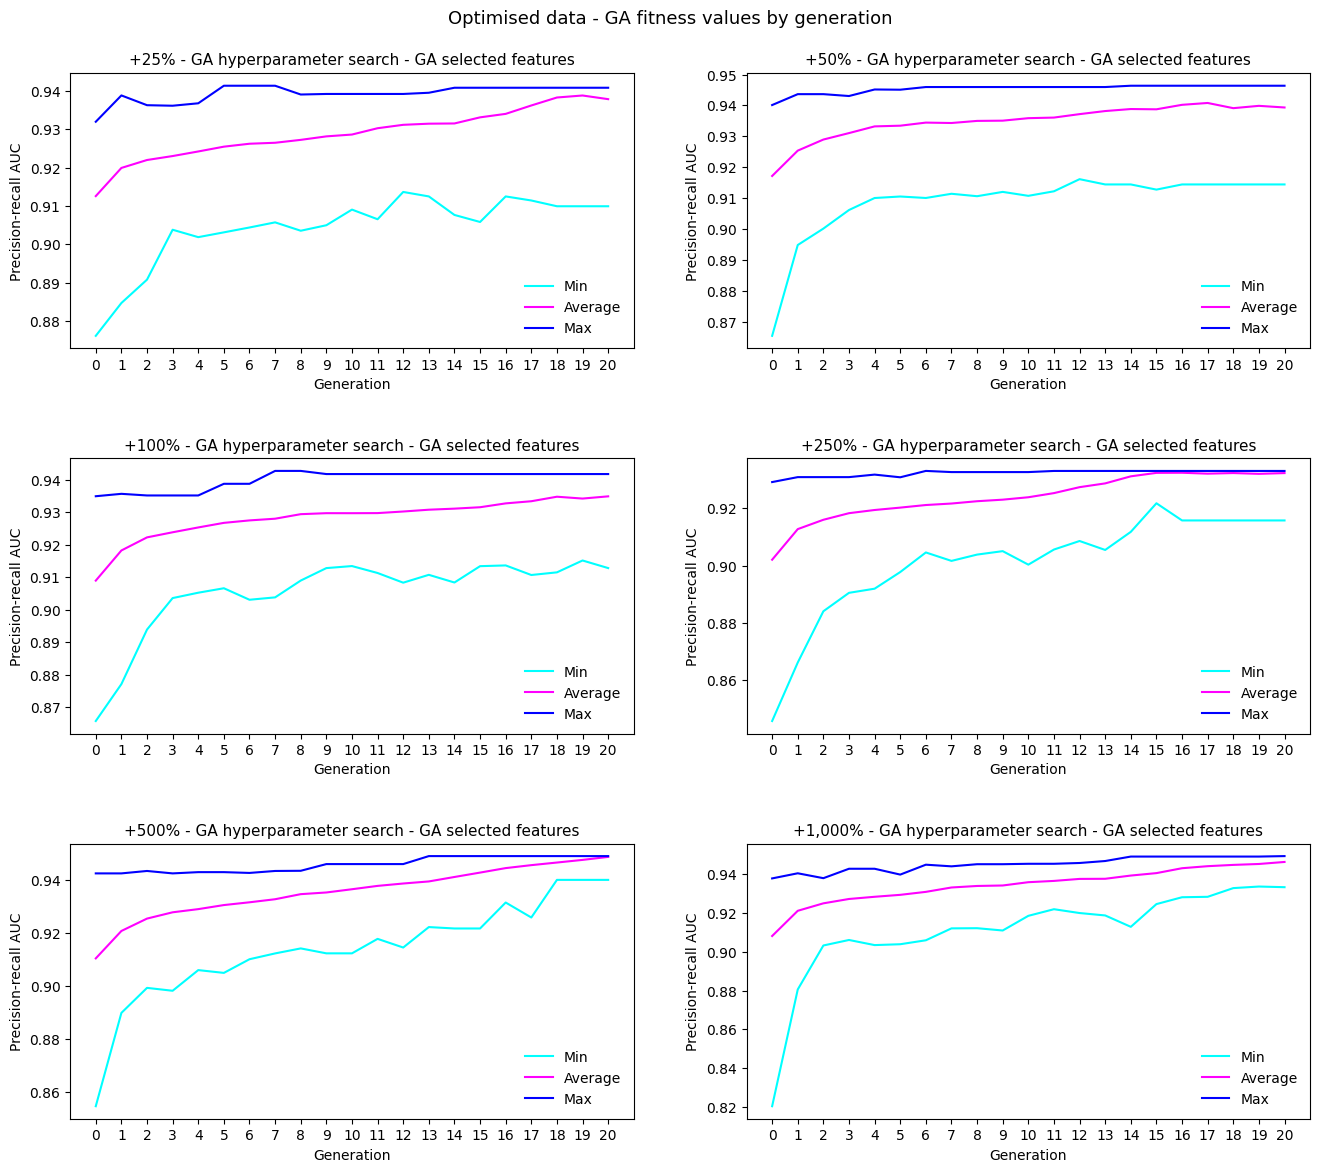

In [ ]:
fig, axes=plt.subplots(3,2,figsize=(16,12.75),gridspec_kw={'hspace': 0.4}) # width by height

#axes[3, 1].set_visible(False)

fit_gen_plot(log_fh_25,    20, '+25% - GA hyperparameter search - GA selected features',       '+25%',        best_fit_score_fh_25_o,   best_hyper_fh_25_o,   0, 0)
fit_gen_plot(log_fh_50,    20, '+50% - GA hyperparameter search - GA selected features',       '+50%',        best_fit_score_fh_50_o,   best_hyper_fh_50_o,   0, 1)
fit_gen_plot(log_fh_100,   20, '+100% - GA hyperparameter search - GA selected features',      '+100%',       best_fit_score_fh_100_o,  best_hyper_fh_100_o,  1, 0)
fit_gen_plot(log_fh_250,   20, '+250% - GA hyperparameter search - GA selected features',      '+250%',       best_fit_score_fh_250_o,  best_hyper_fh_250_o,  1, 1)
fit_gen_plot(log_fh_500,   20, '+500% - GA hyperparameter search - GA selected features',      '+500%',       best_fit_score_fh_500_o,  best_hyper_fh_500_o,  2, 0)
fit_gen_plot(log_fh_1000,  20, '+1,000% - GA hyperparameter search - GA selected features',    '+1,000%',     best_fit_score_fh_1000_o, best_hyper_fh_1000_o, 2, 1)

fig.suptitle('Optimised data - GA fitness values by generation', fontsize=13)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

### **7. Evaluation of models**

#### 7.1. Create metric summary tables

In [ ]:
# Ignore '_bal' - use the '_bal' for RFE features and RS hypers from code IIIa

# GA selection of features - default hyperparameters
metrics_f_all_o=pd.concat([metrics_f_bal, metrics_f_25_o, metrics_f_50_o, metrics_f_100_o, metrics_f_250_o, metrics_f_500_o, metrics_f_1000_o])
# GA selection of hyperparameters - best feature selections from above
metrics_fh_all_o=pd.concat([metrics_fh_bal, metrics_fh_25_o, metrics_fh_50_o, metrics_fh_100_o, metrics_fh_250_o, metrics_fh_500_o, metrics_fh_1000_o])

Save tables

In [ ]:
metrics_f_all_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all_o.pkl')
metrics_fh_all_o.to_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all_o.pkl')

Review tables

In [ ]:
# For both of these tables ignore '_bal' - the correct baseline model is that of code IIIa built with RFE best features and random search hyperparameters and its evaluation metrics are:

#         tp	tn	fp	fn	logloss	accuracy	recall	precision	specificity	f1_score	pr_auc	roc_auc	num_feats
# _bal_o	172	21	26	39	   0.51	 0.75	      0.82	     0.87	   0.45	      0.84	    0.85	 0.61	    14

In [ ]:
# GA features & default hyperparameters
metrics_f_all_o

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,156,35,12,55,0.469490,0.740310,0.739336,0.928571,0.744681,0.823219,0.940606,0.777755,0.859396
_25_o,143,37,10,68,0.471154,0.697674,0.677725,0.934641,0.787234,0.785714,0.943780,0.782192,0.890566
_50_o,148,35,12,63,0.495465,0.709302,0.701422,0.925000,0.744681,0.797844,0.942062,0.764647,0.939961
_100_o,159,33,14,52,0.480700,0.744186,0.753555,0.919075,0.702128,0.828125,0.945432,0.784814,0.965836
_250_o,144,34,13,67,0.552227,0.689922,0.682464,0.917197,0.723404,0.782609,0.935251,0.754966,0.981528
_500_o,153,32,15,58,0.511203,0.717054,0.725118,0.910714,0.680851,0.807388,0.935096,0.757185,0.993948
_1000_o,149,32,15,62,0.540613,0.701550,0.706161,0.908537,0.680851,0.794667,0.937627,0.755269,0.996230


In [ ]:
# Optimised CTGAN data - features & hyperparameters GA
metrics_fh_all_o

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,135,41,6,76,0.434393,0.682171,0.639810,0.957447,0.872340,0.767045,0.945899,0.793183,0.872660
_25_o,169,33,14,42,0.410488,0.782946,0.800948,0.923497,0.702128,0.857868,0.945507,0.792074,0.887306
_50_o,143,39,8,68,0.508325,0.705426,0.677725,0.947020,0.829787,0.790055,0.948054,0.780478,0.935298
_100_o,120,43,4,91,0.420769,0.631783,0.568720,0.967742,0.914894,0.716418,0.947756,0.786427,0.965157
_250_o,155,34,13,56,0.495472,0.732558,0.734597,0.922619,0.723404,0.817942,0.942185,0.778159,0.979181
_500_o,169,29,18,42,0.406961,0.767442,0.800948,0.903743,0.617021,0.849246,0.939075,0.774024,0.994299
_1000_o,135,39,8,76,0.502462,0.674419,0.639810,0.944056,0.829787,0.762712,0.940896,0.771100,0.996448


#### 7.2. Create PR-AUC & ROC-AUC plots

##### GA feats & default hypers vs GA feats & GA hypers


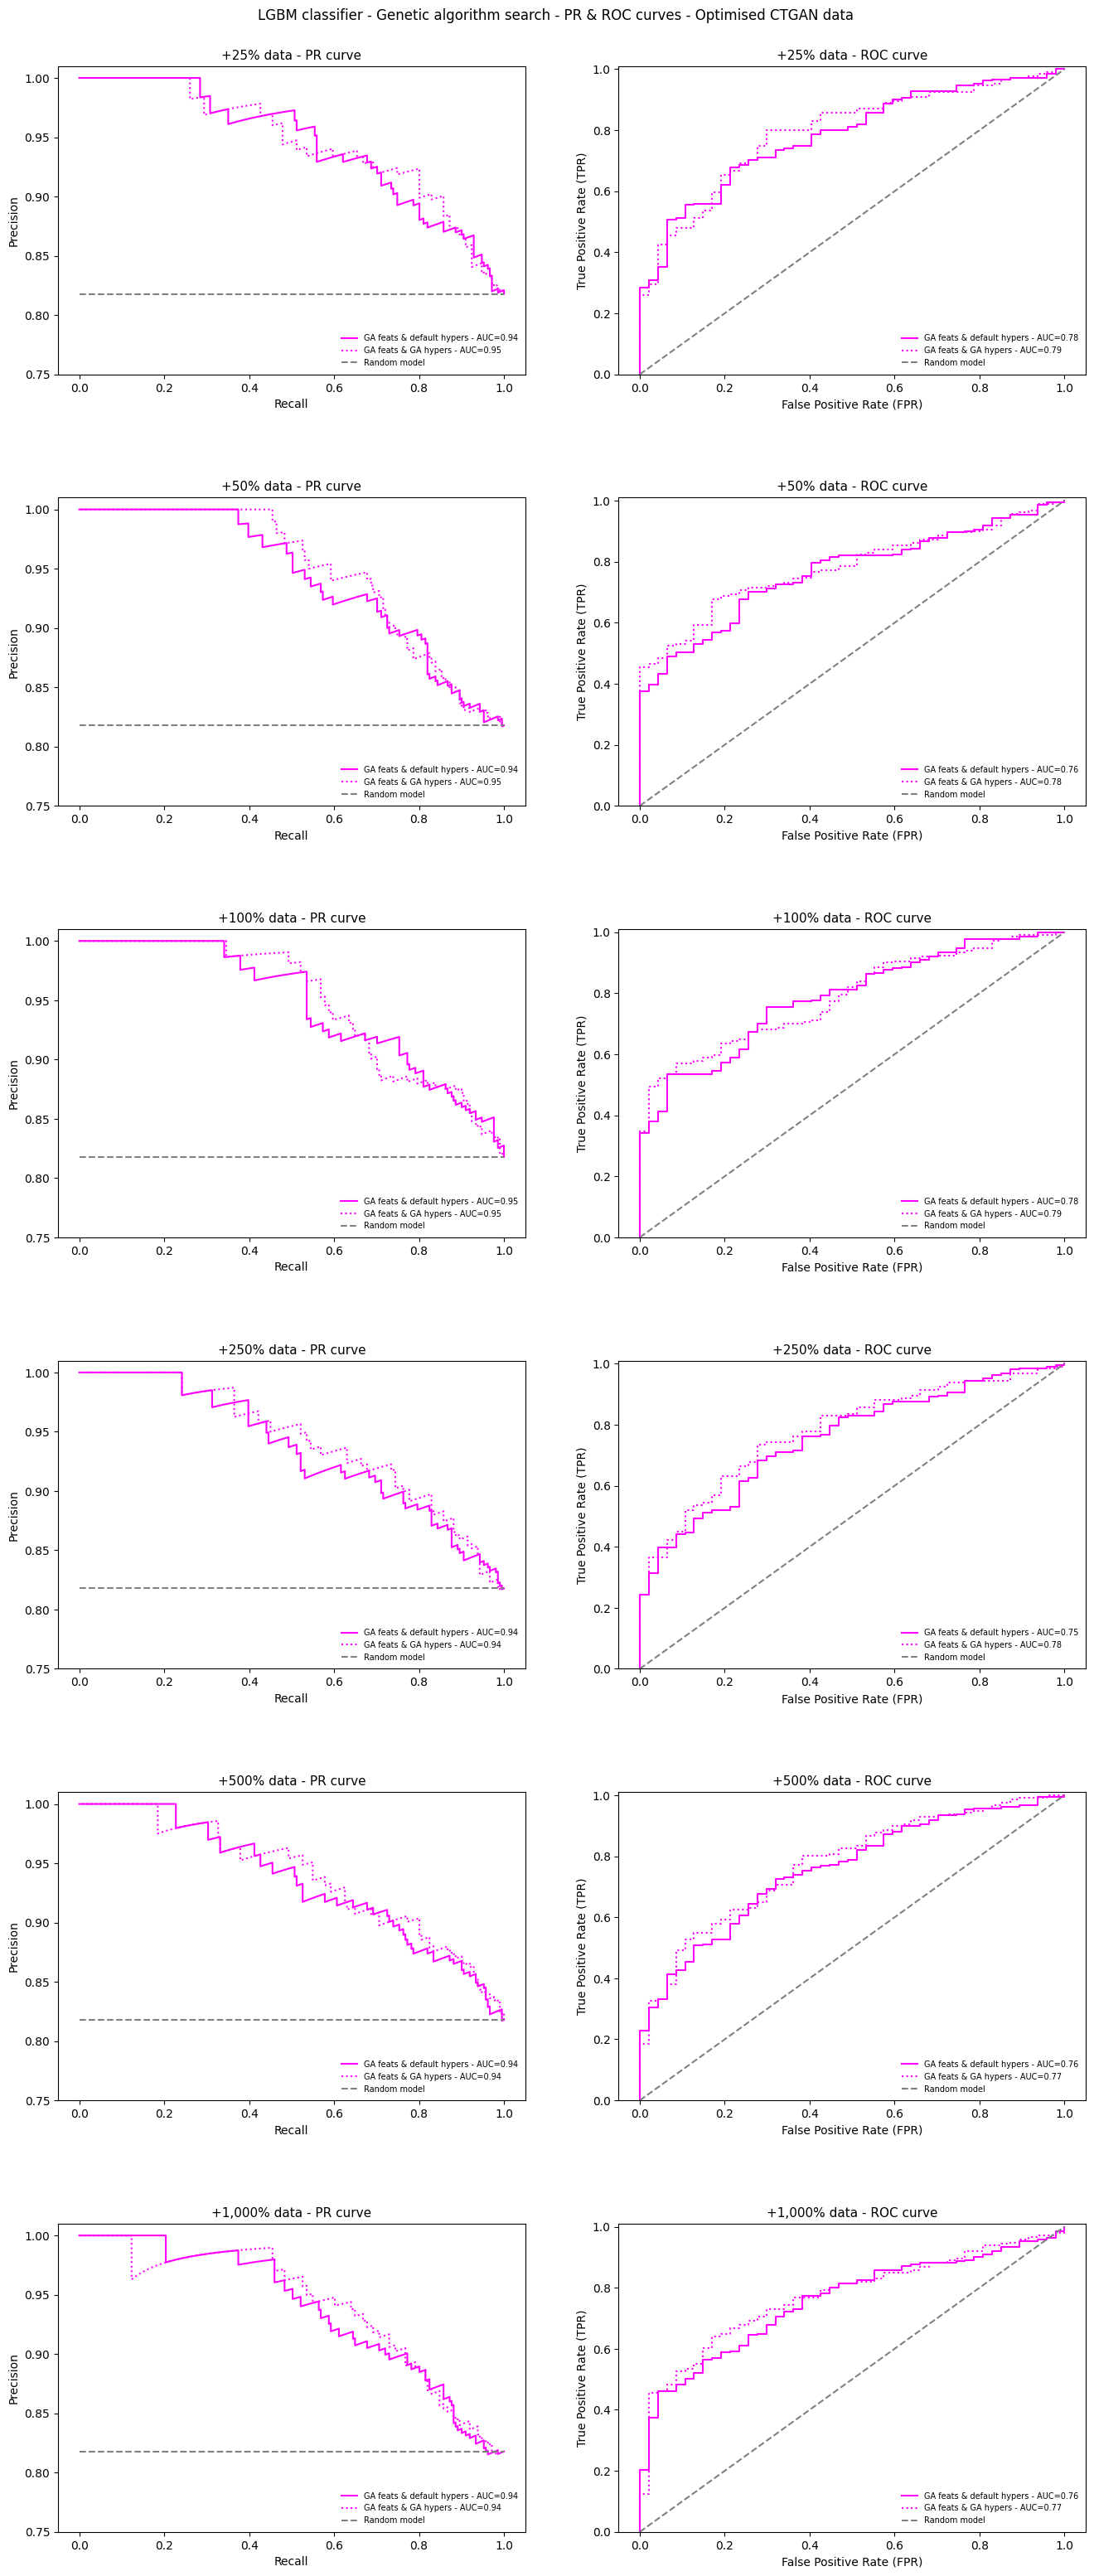

In [ ]:
fig, axes=plt.subplots(6,2,figsize=(16,35),gridspec_kw={'hspace': 0.4}) # Width by height

##### +25% #####
auc_curves2(# PR curve
            pr_curve_dic_f_25_o['_25_o'],   pr_curve_dic_fh_25_o['_25_o'],
            # ROC curve
            roc_curve_dic_f_25_o['_25_o'],  roc_curve_dic_fh_25_o['_25_o'],
            # Title
            '+25% data',
            # Subplot positions - row=i, col0=j, col1=k
            0,0,1)

##### +50% #####
auc_curves2(# PR curve
            pr_curve_dic_f_50_o['_50_o'],   pr_curve_dic_fh_50_o['_50_o'],
            # ROC curve
            roc_curve_dic_f_50_o['_50_o'],  roc_curve_dic_fh_50_o['_50_o'],
            # Title
            '+50% data',
            # Subplot positions - row=i, col0=j, col1=k
            1,0,1)

##### +100% #####
auc_curves2(# PR curve
            pr_curve_dic_f_100_o['_100_o'],   pr_curve_dic_fh_100_o['_100_o'],
            # ROC curve
            roc_curve_dic_f_100_o['_100_o'],  roc_curve_dic_fh_100_o['_100_o'],
            # Title
            '+100% data',
            # Subplot positions - row=i, col0=j, col1=k
            2,0,1)

##### +250% #####
auc_curves2(# PR curve
            pr_curve_dic_f_250_o['_250_o'],   pr_curve_dic_fh_250_o['_250_o'],
            # ROC curve
            roc_curve_dic_f_250_o['_250_o'],  roc_curve_dic_fh_250_o['_250_o'],
            # Title
            '+250% data',
            # Subplot positions - row=i, col0=j, col1=k
            3,0,1)

# ##### +500% #####
auc_curves2(# PR curve
            pr_curve_dic_f_500_o['_500_o'],   pr_curve_dic_fh_500_o['_500_o'],
            # ROC curve
            roc_curve_dic_f_500_o['_500_o'],  roc_curve_dic_fh_500_o['_500_o'],
            # Title
            '+500% data',
            # Subplot positions - row=i, col0=j, col1=k
            4,0,1)

##### +1000% #####
auc_curves2(# PR curve
            pr_curve_dic_f_1000_o['_1000_o'],   pr_curve_dic_fh_1000_o['_1000_o'],
            # ROC curve
            roc_curve_dic_f_1000_o['_1000_o'],  roc_curve_dic_fh_1000_o['_1000_o'],
            # Title
            '+1,000% data',
            # Subplot positions - row=i, col0=j, col1=k
            5,0,1)

fig.suptitle('LGBM classifier - Genetic algorithm search - PR & ROC curves - Optimised CTGAN data', fontsize=12)
fig.subplots_adjust(top=0.96)

plt.tight_layout()
plt.show()

#### 7.3. Feature rank plots

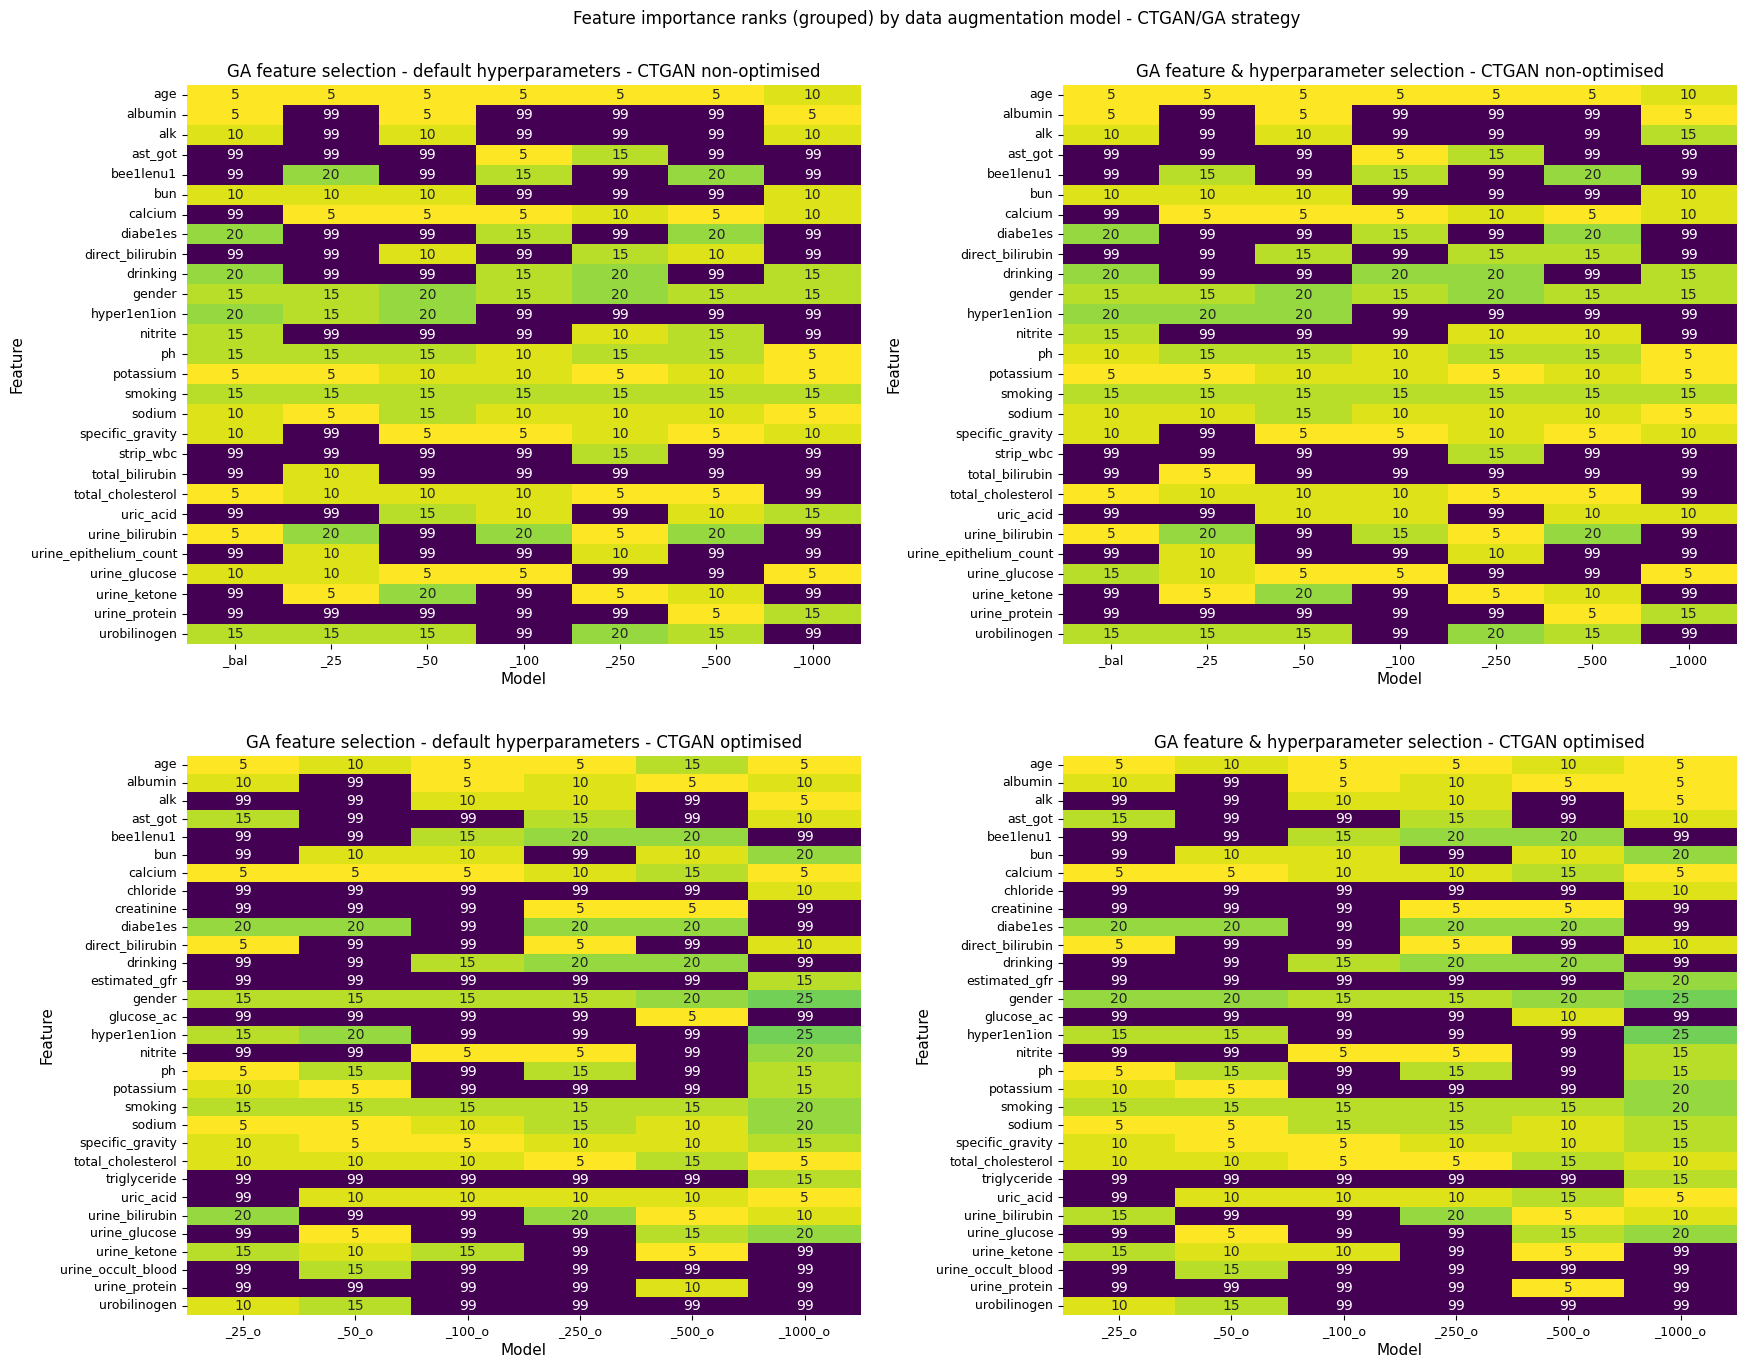

In [ ]:
########### Pull together the ranks for each augmentation scenario into one dataframe ##########

# GA feats & default hypers
opt_f=feat_imp_f_25_o
for i in [feat_imp_f_50_o, feat_imp_f_100_o, feat_imp_f_250_o, feat_imp_f_500_o, feat_imp_f_1000_o]:
  opt_f=pd.merge(opt_f, i, on='feature', how='outer')

# GA feats & hypers
opt_fh=feat_imp_fh_25_o
for i in [feat_imp_fh_50_o, feat_imp_fh_100_o, feat_imp_fh_250_o, feat_imp_fh_500_o, feat_imp_fh_1000_o]:
  opt_fh=pd.merge(opt_fh, i, on='feature', how='outer')

########### Plot heatmaps ##########

# Ignore first two plots - old work using non-optimised GAN data

fig,axes=plt.subplots(2,2,figsize=(20,15),gridspec_kw={'hspace': 0.2, 'wspace': 0.3}) # width by height

feat_heatmap(non_opt_f,  'GA feature selection - default hyperparameters - CTGAN non-optimised',    0, 0,)
feat_heatmap(non_opt_fh, 'GA feature & hyperparameter selection - CTGAN non-optimised',             0, 1,)
feat_heatmap(opt_f,      'GA feature selection - default hyperparameters - CTGAN optimised',        1, 0, 1)
feat_heatmap(opt_fh,     'GA feature & hyperparameter selection - CTGAN optimised',                 1, 1, 1)

fig.suptitle('Feature importance ranks (grouped) by data augmentation model - CTGAN/GA strategy', fontsize=12)
fig.subplots_adjust(top=0.93)

plt.tight_layout()
plt.show()

### **8. Calibration checks**

Calibration tells us how much we can trust a model's predictions

- When working with machine learning classifiers, it might be desirable to have the model predict probabilities of data belonging to each possible class instead of crude class labels
- Model calibration is extremely valuable to us in cases where predicted probability is of interest like bladder cancer prediction
- Calibration is the process of ensuring that the predicted probabilities reflect the true likelihood of the corresponding outcomes
- For example, if for all test samples given a probability score between 0.3 and 0.4 (probability bin 0.3-0.4 with mean probability=0.35) the proportion of actual events ('1's) are in the same range of 0.3-0.4 then the model is well calibrated for this bin
- A 'reliability plot' shows the proportion of actual '1's on y-axis for the samples in each x-axis probability score bin (which is usually represented by its mean probability score)
- If the fraction of actual '1's for each bin is close to the diagonal then the model is well calibrated. If the plot is above the diagonal for any probability scores (bin) then it means the model is under-confident and the probability scores (as per the x-axis bin) are too low. If the plot is below the diagonal for any probability scores (bin) then it means the model is over-confident and the probability scores (as per the x-axis bin) are too high
- Can also use the Brier score to check for accuracy which is simply the square of the difference between probability score and actual value (0 or 1) for each sample, then takes an average across all scores (all samples)
- If probability scores are not well calibrated can try recalibration using Platt scaling (applying a sigmoid function) and Isotonic Regression
- Platt is used for smaller datasets where reliability plot shape is sigmoid
- Isotonic Regression is for larger datasets (>1,000 samples) but doesn't require the reliability curve to be sigmoid shaped


#### 8.1. Create calibration plots

Get data

In [11]:
##### Baseline #####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_o_rs', 'rb') as file:
  y_pred_bl=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_names_bal_o_rs', 'rb') as file:
  feats_bl=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/hypers_bal_o_rs', 'rb') as file:
  hypers_bl=pickle.load(file)

##### +25% model #####

# feats
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25_o','rb') as file:
    feats_25=pickle.load(file)

# hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25_o','rb') as file:
    hypers_25=pickle.load(file)

model=lgb.LGBMClassifier(**hypers_25)
model.set_params(verbose=-1)
model.fit(x_train_25_o[feats_25], y_train_25_o)
y_pred_25=model.predict_proba(x_test_25_o[feats_25])[:, 1]

##### +50% model #####

# feats
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o','rb') as file:
    feats_50=pickle.load(file)

# hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o','rb') as file:
    hypers_50=pickle.load(file)

model=lgb.LGBMClassifier(**hypers_50)
model.set_params(verbose=-1)
model.fit(x_train_50_o[feats_50], y_train_50_o)
y_pred_50=model.predict_proba(x_test_50_o[feats_50])[:, 1]

##### +100% model #####

# feats
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100_o','rb') as file:
    feats_100=pickle.load(file)

# hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100_o','rb') as file:
    hypers_100=pickle.load(file)

model=lgb.LGBMClassifier(**hypers_100)
model.set_params(verbose=-1)
model.fit(x_train_100_o[feats_100], y_train_100_o)
y_pred_100=model.predict_proba(x_test_100_o[feats_100])[:, 1]

##### +250% model #####

# feats
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250_o','rb') as file:
    feats_250=pickle.load(file)

# hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250_o','rb') as file:
    hypers_250=pickle.load(file)

model=lgb.LGBMClassifier(**hypers_250)
model.set_params(verbose=-1)
model.fit(x_train_250_o[feats_250], y_train_250_o)
y_pred_250=model.predict_proba(x_test_250_o[feats_250])[:, 1]

##### +500% model #####

# feats
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500_o','rb') as file:
    feats_500=pickle.load(file)

# hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500_o','rb') as file:
    hypers_500=pickle.load(file)

model=lgb.LGBMClassifier(**hypers_500)
model.set_params(verbose=-1)
model.fit(x_train_500_o[feats_500], y_train_500_o)
y_pred_500=model.predict_proba(x_test_500_o[feats_500])[:, 1]

##### +1,000% model #####

# feats
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000_o','rb') as file:
    feats_1000=pickle.load(file)

# hypers
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000_o','rb') as file:
    hypers_1000=pickle.load(file)

model=lgb.LGBMClassifier(**hypers_1000)
model.set_params(verbose=-1)
model.fit(x_train_1000_o[feats_1000], y_train_1000_o)
y_pred_1000=model.predict_proba(x_test_1000_o[feats_1000])[:, 1]

Try Platt method with Sigmoid transformation

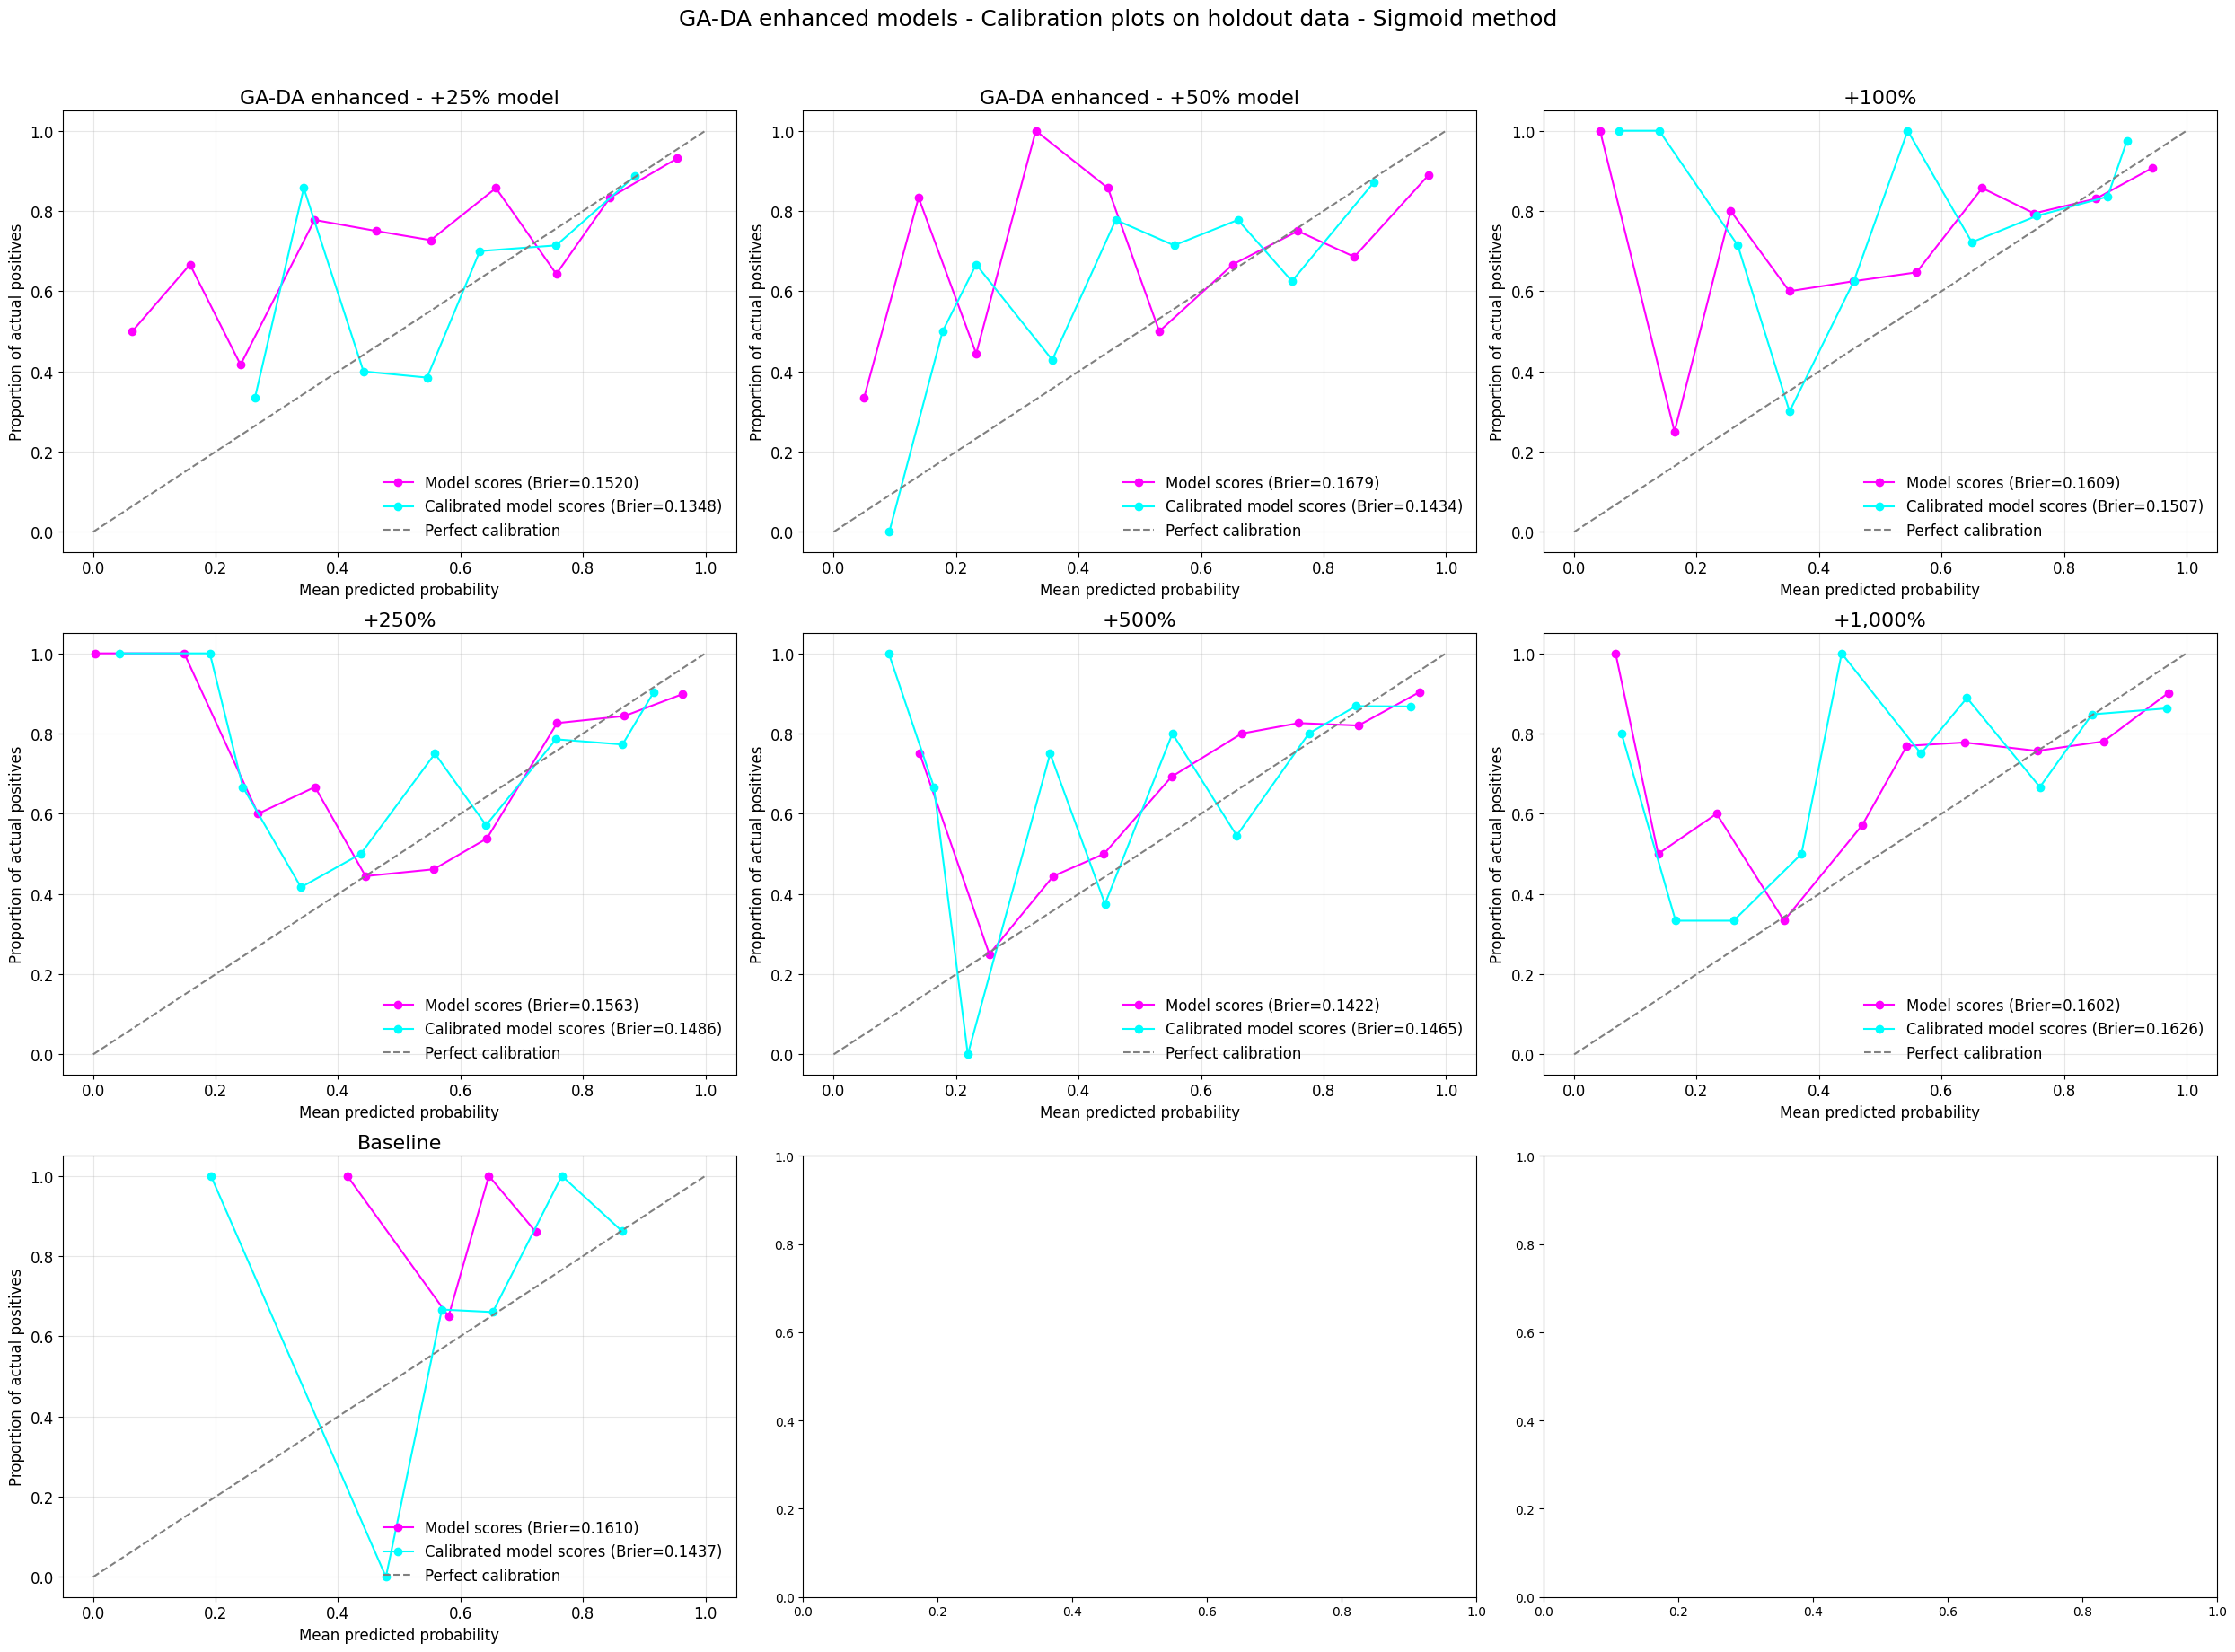

In [12]:
fig,axes = plt.subplots(3,3,figsize=(25,18))

y_pred_cal_sig_25       = calibration_plot(y_pred_25,   feats_25,   hypers_25,   x_train_25_o,    y_train_25_o,    x_test_25_o,    y_test_25_o,   'sigmoid', 'GA-DA enhanced - +25% model',    0,0)
y_pred_cal_sig_50       = calibration_plot(y_pred_50,   feats_50,   hypers_50,   x_train_50_o,    y_train_50_o,    x_test_50_o,    y_test_50_o,   'sigmoid', 'GA-DA enhanced - +50% model',    0,1)
y_pred_cal_sig_100      = calibration_plot(y_pred_100,  feats_100,  hypers_100,  x_train_100_o,   y_train_100_o,   x_test_100_o,   y_test_100_o,  'sigmoid', '+100%',   0,2)
y_pred_cal_sig_250      = calibration_plot(y_pred_250,  feats_250,  hypers_250,  x_train_250_o,   y_train_250_o,   x_test_250_o,   y_test_250_o,  'sigmoid', '+250%',   1,0)
y_pred_cal_sig_500      = calibration_plot(y_pred_500,  feats_500,  hypers_500,  x_train_500_o,   y_train_500_o,   x_test_500_o,   y_test_500_o,  'sigmoid', '+500%',   1,1)
y_pred_cal_sig_1000     = calibration_plot(y_pred_1000, feats_1000, hypers_1000, x_train_1000_o,  y_train_1000_o,  x_test_1000_o,  y_test_1000_o, 'sigmoid', '+1,000%', 1,2)
y_pred_cal_sig_bl       = calibration_plot(y_pred_bl,   feats_bl,   hypers_bl,   x_train_bal_o,   y_train_bal_o,   x_test_bal_o,   y_test_bal_o,  'sigmoid', 'Baseline',2,0)

fig.suptitle('GA-DA enhanced models - Calibration plots on holdout data - Sigmoid method', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

Try Isotonic transformation

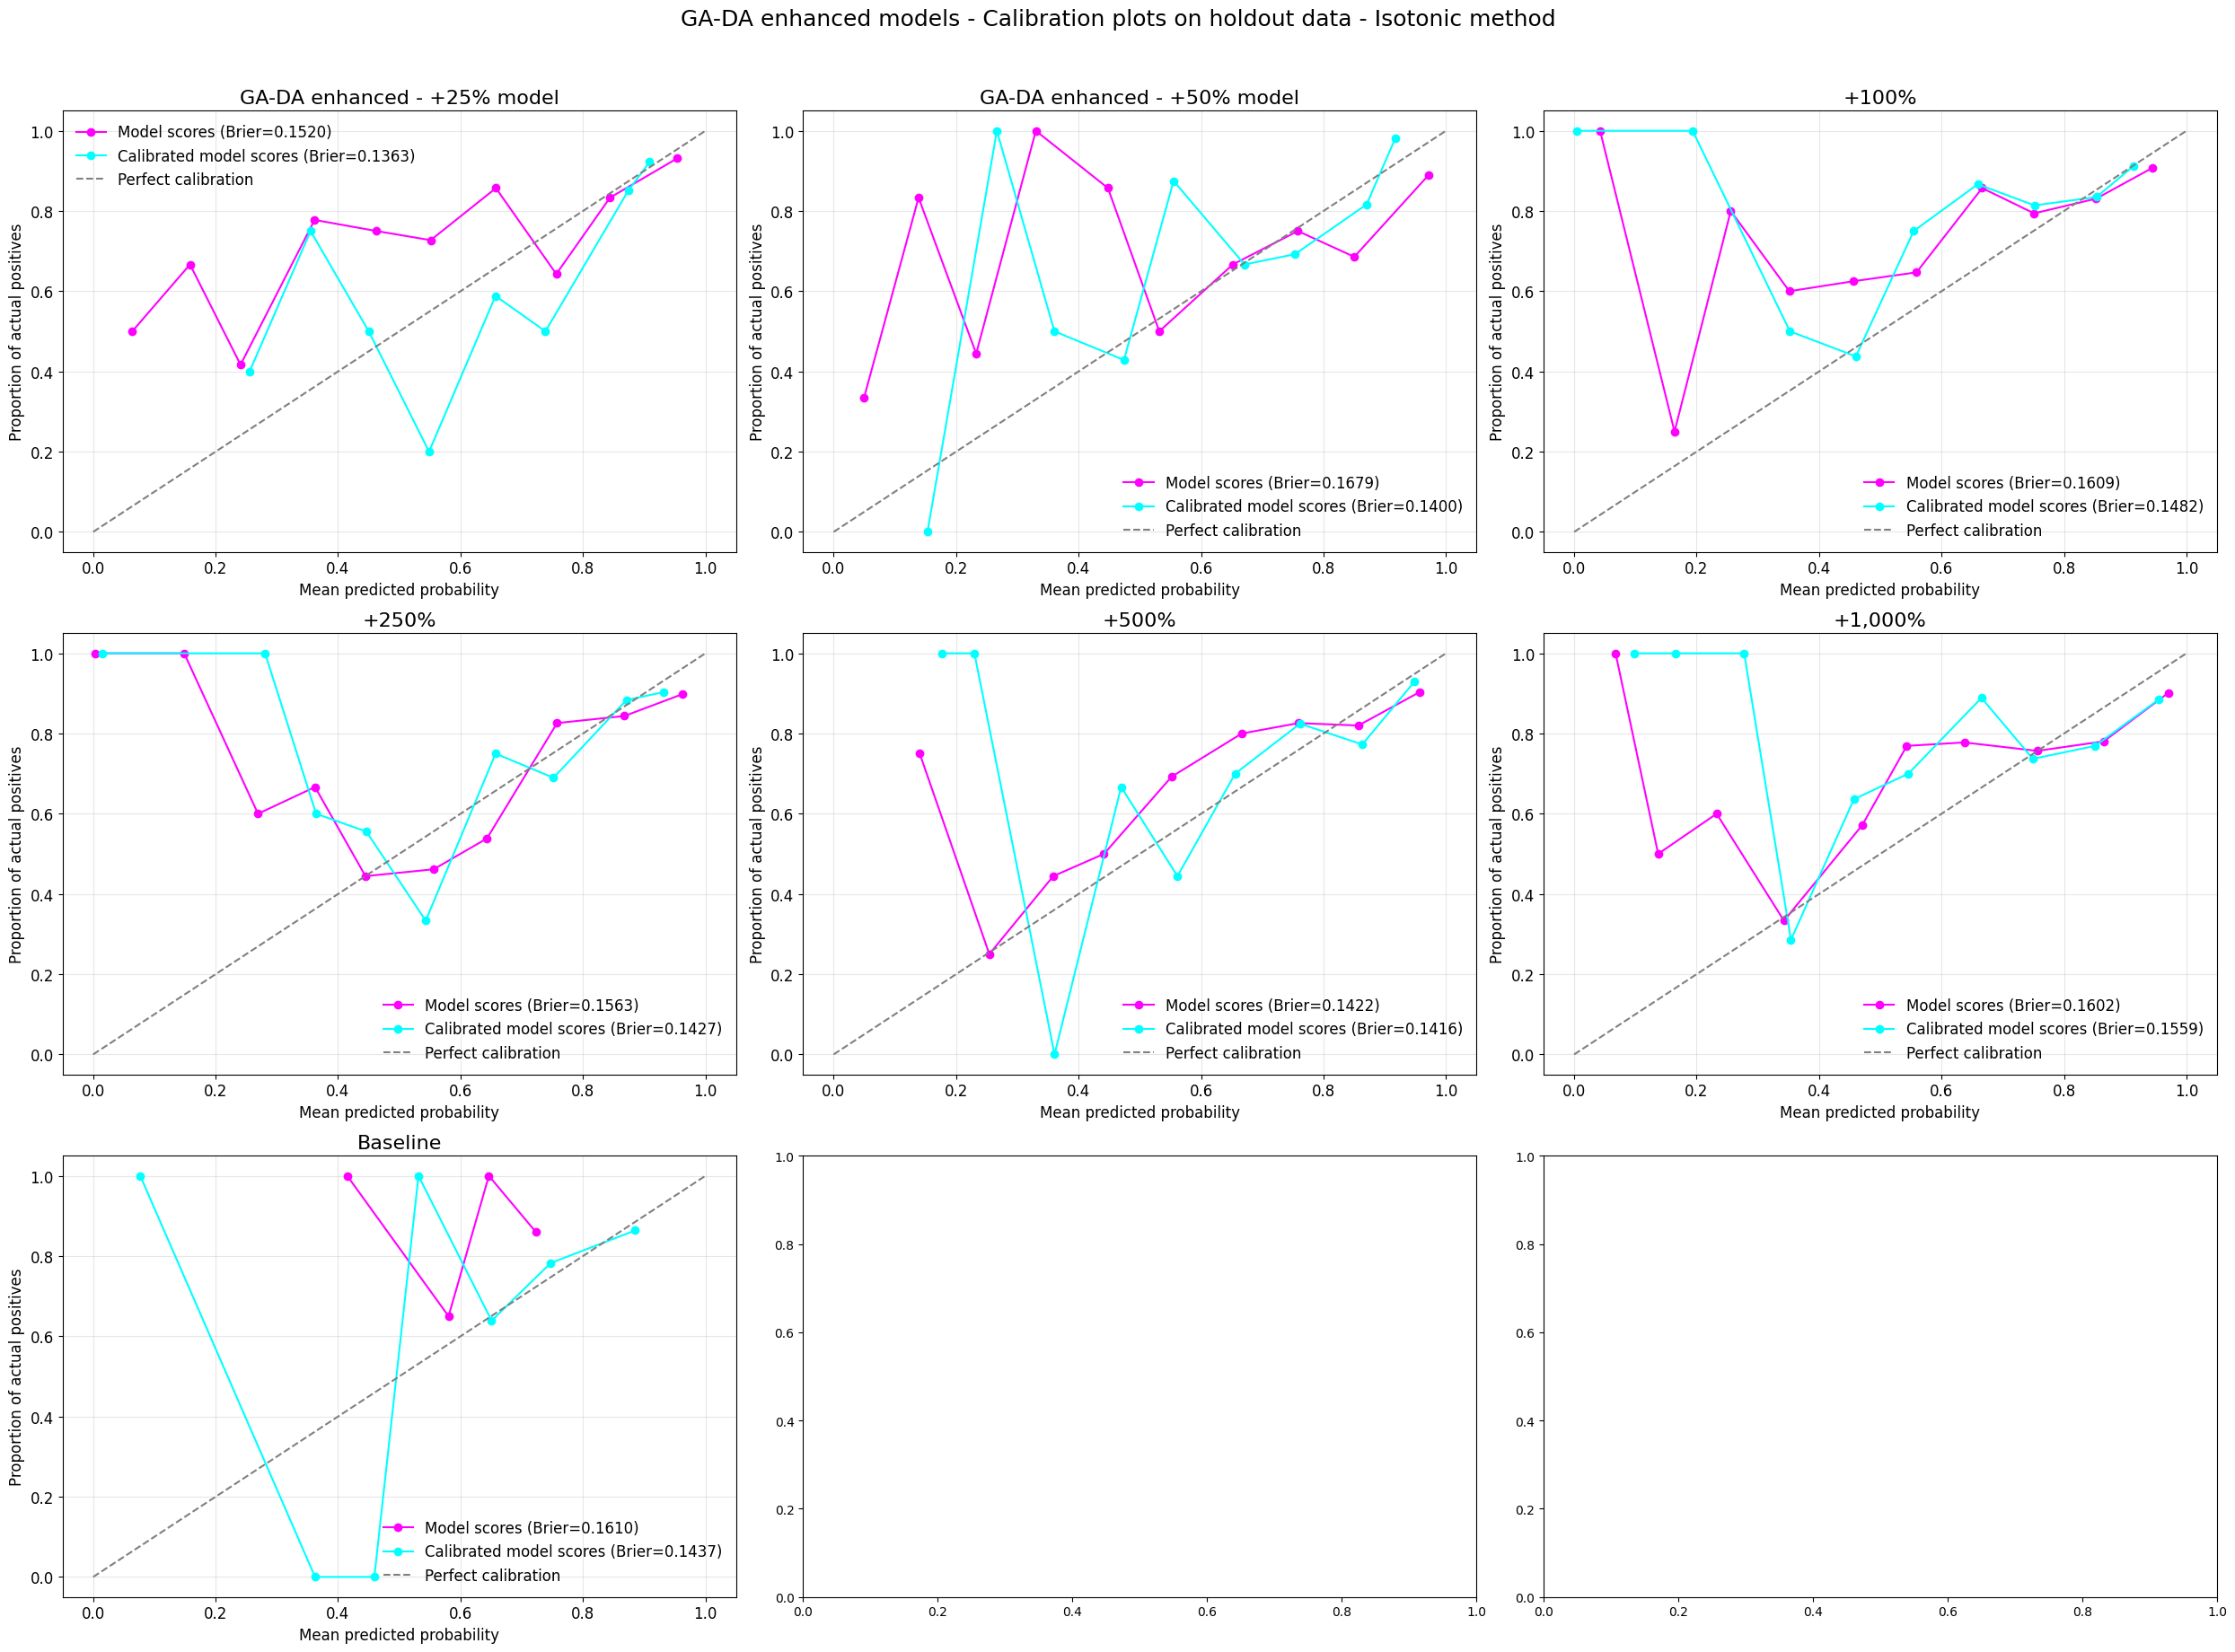

In [13]:
fig,axes = plt.subplots(3,3,figsize=(25,18))

y_pred_cal_iso_25       = calibration_plot(y_pred_25,   feats_25,   hypers_25,   x_train_25_o,    y_train_25_o,    x_test_25_o,    y_test_25_o,   'isotonic', 'GA-DA enhanced - +25% model',    0,0)
y_pred_cal_iso_50       = calibration_plot(y_pred_50,   feats_50,   hypers_50,   x_train_50_o,    y_train_50_o,    x_test_50_o,    y_test_50_o,   'isotonic', 'GA-DA enhanced - +50% model',    0,1)
y_pred_cal_iso_100      = calibration_plot(y_pred_100,  feats_100,  hypers_100,  x_train_100_o,   y_train_100_o,   x_test_100_o,   y_test_100_o,  'isotonic', '+100%',   0,2)
y_pred_cal_iso_250      = calibration_plot(y_pred_250,  feats_250,  hypers_250,  x_train_250_o,   y_train_250_o,   x_test_250_o,   y_test_250_o,  'isotonic', '+250%',   1,0)
y_pred_cal_iso_500      = calibration_plot(y_pred_500,  feats_500,  hypers_500,  x_train_500_o,   y_train_500_o,   x_test_500_o,   y_test_500_o,  'isotonic', '+500%',   1,1)
y_pred_cal_iso_1000     = calibration_plot(y_pred_1000, feats_1000, hypers_1000, x_train_1000_o,  y_train_1000_o,  x_test_1000_o,  y_test_1000_o, 'isotonic', '+1,000%', 1,2)
y_pred_cal_iso_bl       = calibration_plot(y_pred_bl,   feats_bl,   hypers_bl,   x_train_bal_o,   y_train_bal_o,   x_test_bal_o,   y_test_bal_o,  'isotonic', 'Baseline',2,0)

fig.suptitle('GA-DA enhanced models - Calibration plots on holdout data - Isotonic method', fontsize=18, y=1.02)
fig.tight_layout()
plt.show()

After review:
1. Use the calibrated sigmoid predictions for Baseline, +25%, +50%
2. Use the calibrated isotonic predictions for +250%
3. The rest stay the same as gain in Brier loss score not significant and the transformation may be overfitting

#### 8.2. Show changes in distribution of probability scores post-calibration
Note that the gray vertical line represents the proportion of BC samples in  hold-out data

In [ ]:
# Bring probability scores together
all_bl        ={'Uncalibrated': y_pred_bl,  'Calibrated-Sigmoid':y_pred_cal_sig_bl,        'Calibrated-Isotonic':y_pred_cal_iso_bl}
all_25        ={'Uncalibrated': y_pred_25,  'Calibrated-Sigmoid':y_pred_cal_sig_25,        'Calibrated-Isotonic':y_pred_cal_iso_25}
all_50        ={'Uncalibrated': y_pred_50,  'Calibrated-Sigmoid':y_pred_cal_sig_50,        'Calibrated-Isotonic':y_pred_cal_iso_50}
all_100       ={'Uncalibrated': y_pred_100, 'Calibrated-Sigmoid':y_pred_cal_sig_100,       'Calibrated-Isotonic':y_pred_cal_iso_100}
all_250       ={'Uncalibrated': y_pred_250, 'Calibrated-Sigmoid':y_pred_cal_sig_250,       'Calibrated-Isotonic':y_pred_cal_iso_250}
all_500       ={'Uncalibrated': y_pred_500, 'Calibrated-Sigmoid':y_pred_cal_sig_500,       'Calibrated-Isotonic':y_pred_cal_iso_500}
all_1000      ={'Uncalibrated': y_pred_1000,'Calibrated-Sigmoid':y_pred_cal_sig_1000,      'Calibrated-Isotonic':y_pred_cal_iso_1000}

all_bl_df       =pd.DataFrame(all_bl)
all_25_df       =pd.DataFrame(all_25)
all_50_df       =pd.DataFrame(all_50)
all_100_df      =pd.DataFrame(all_100)
all_250_df      =pd.DataFrame(all_250)
all_500_df      =pd.DataFrame(all_500)
all_1000_df     =pd.DataFrame(all_1000)

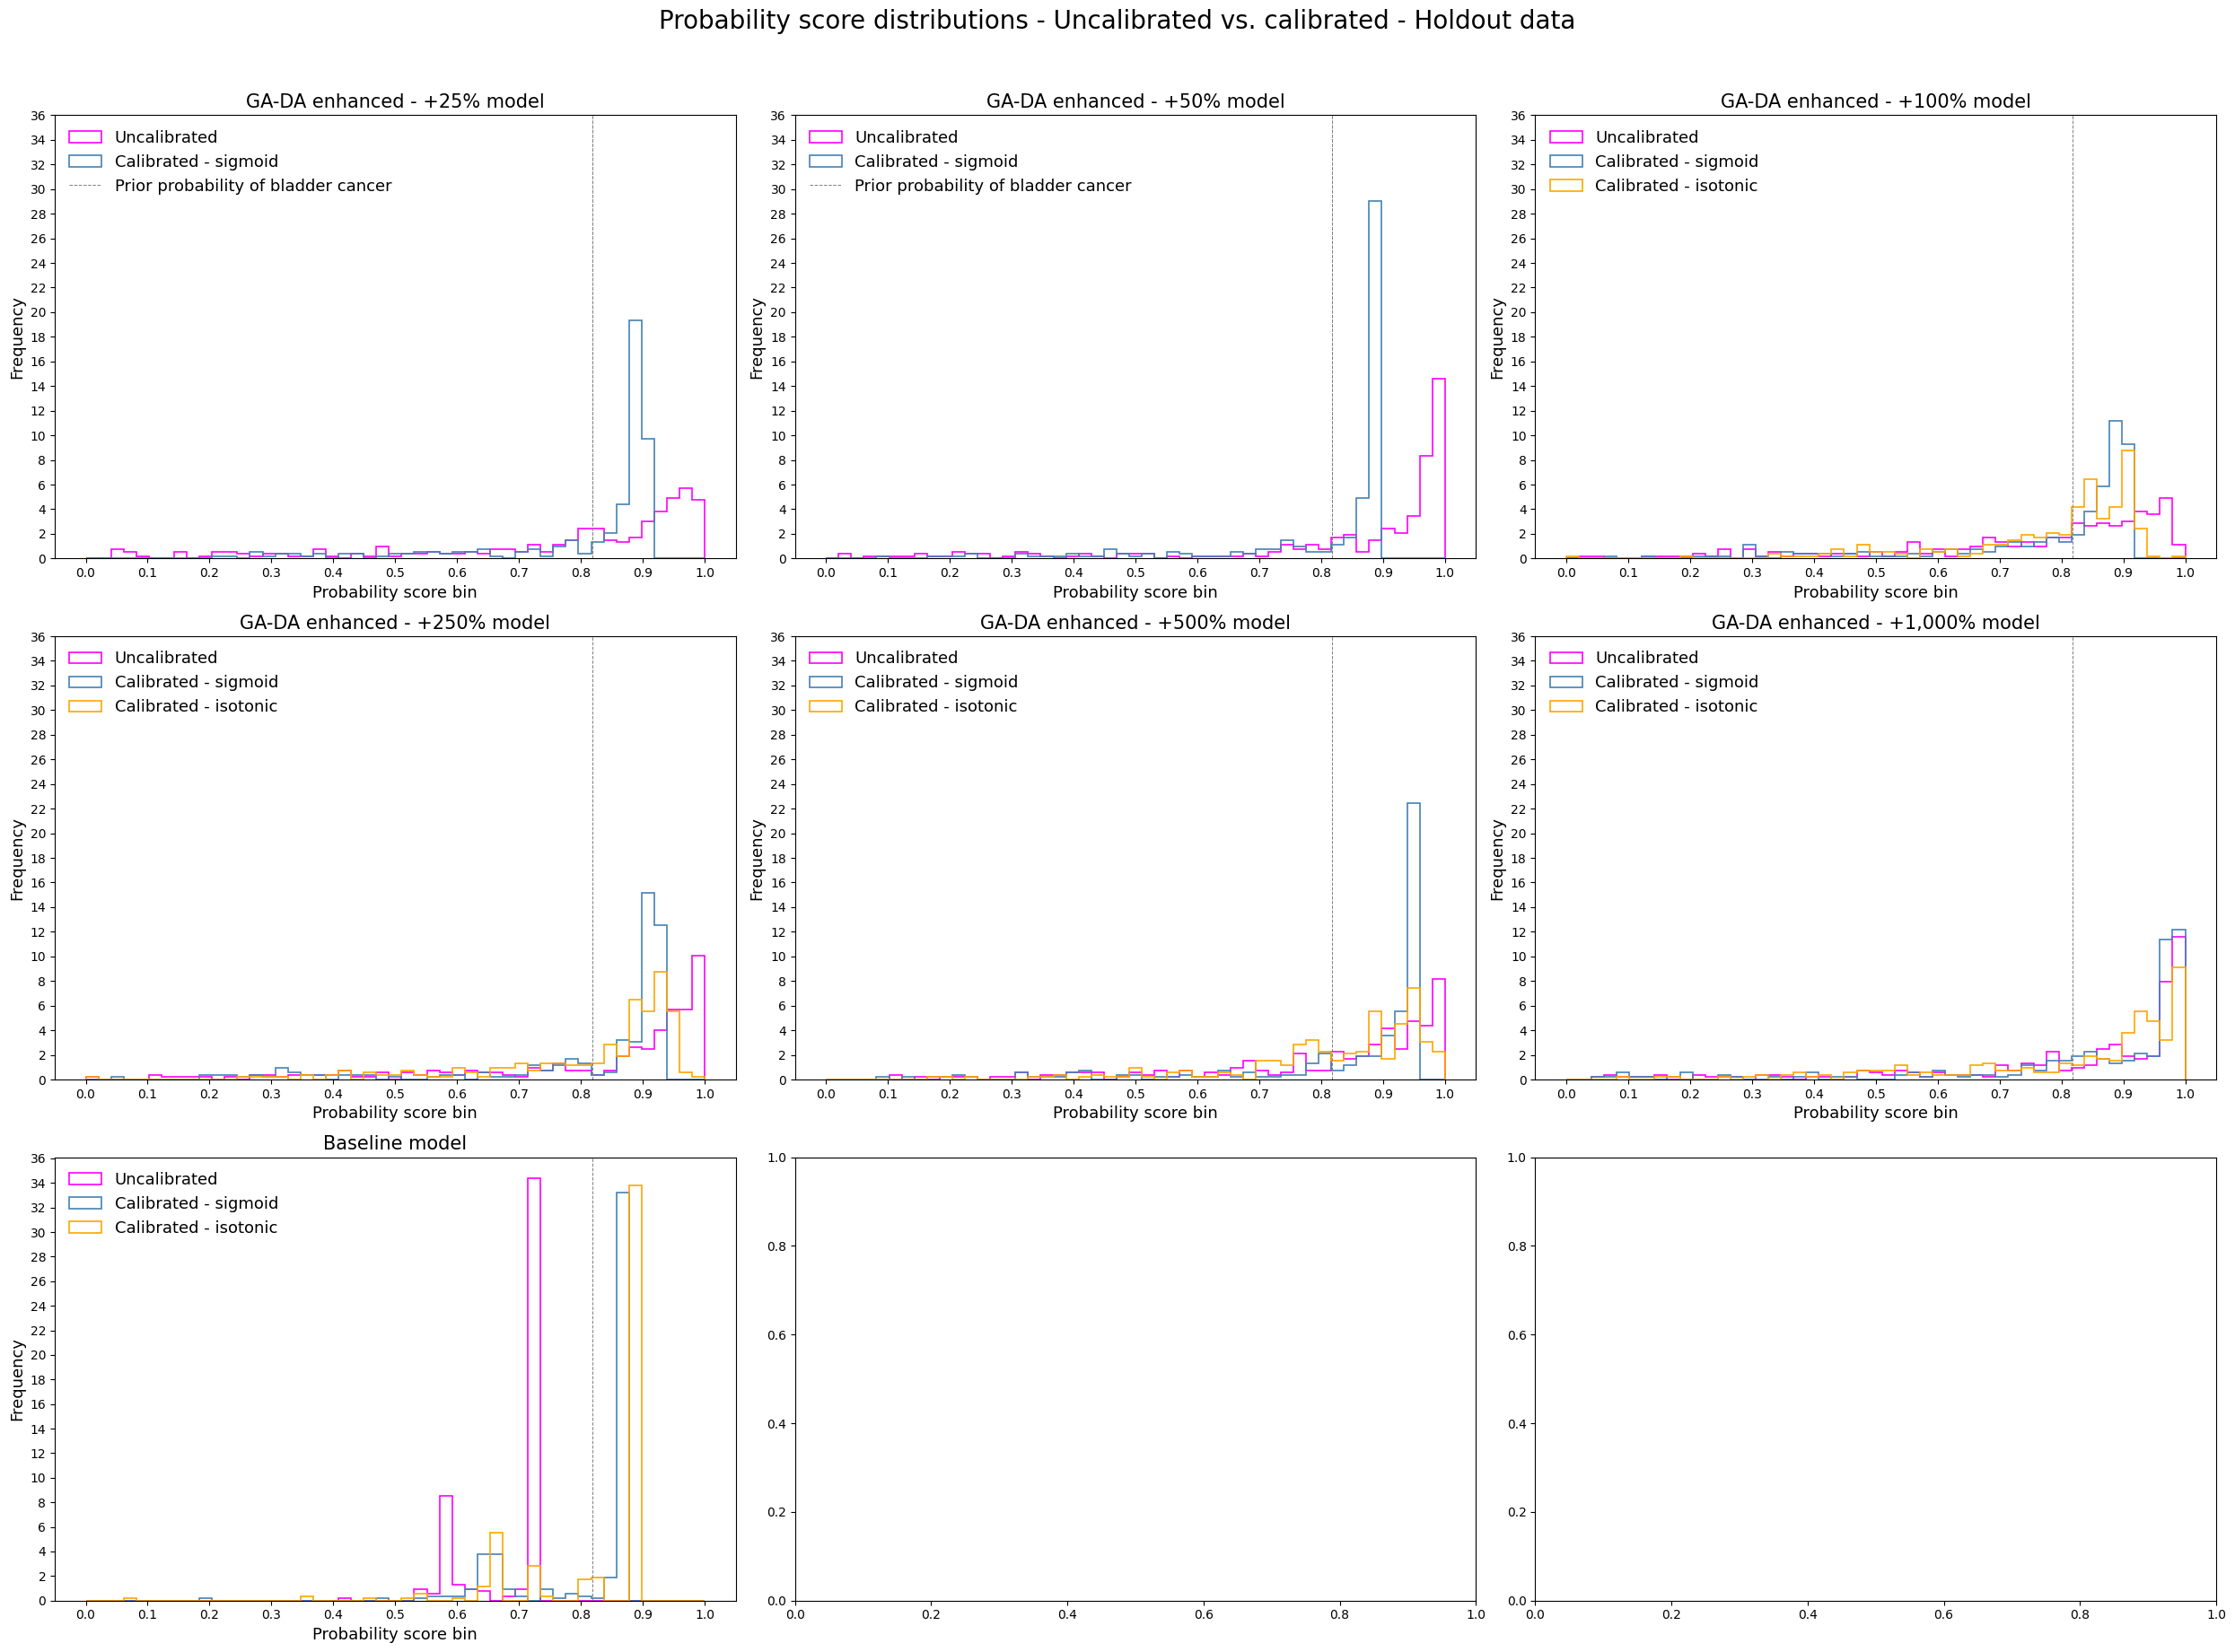

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(25, 18))

# Create the bins
bins = np.linspace(0, 1, 50)

# Plot histograms
fig.suptitle('Probability score distributions - Uncalibrated vs. calibrated - Holdout data', fontsize=20, y=1.02)

axes[0,0].hist(all_25_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0,0].hist(all_25_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
#axes[0,0].hist(all_25_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0,0].set_xticks(np.arange(0, 1.1, 0.1))
axes[0,0].set_yticks(np.arange(0, 38, 2))
axes[0,0].set_xlabel('Probability score bin',fontsize=13)
axes[0,0].set_ylabel('Frequency', fontsize=13)
axes[0,0].set_title('GA-DA enhanced - +25% model', fontsize=15)
axes[0,0].legend(fontsize=13,frameon=False)

axes[0,1].hist(all_50_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0,1].hist(all_50_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0,1].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
#axes[0,1].hist(all_50_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0,1].set_xticks(np.arange(0, 1.1, 0.1))
axes[0,1].set_yticks(np.arange(0, 38, 2))
axes[0,1].set_xlabel('Probability score bin',fontsize=13)
axes[0,1].set_ylabel('Frequency', fontsize=13)
axes[0,1].set_title('GA-DA enhanced - +50% model', fontsize=15)
axes[0,1].legend(fontsize=13,frameon=False)

axes[0,2].hist(all_100_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[0,2].hist(all_100_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[0,2].hist(all_100_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[0,2].set_xticks(np.arange(0, 1.1, 0.1))
axes[0,2].set_yticks(np.arange(0, 38, 2))
axes[0,2].set_xlabel('Probability score bin',fontsize=13)
axes[0,2].set_ylabel('Frequency', fontsize=13)
axes[0,2].set_title('GA-DA enhanced - +100% model', fontsize=15)
axes[0,2].legend(fontsize=13,frameon=False)

axes[1,0].hist(all_250_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[1,0].hist(all_250_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[1,0].hist(all_250_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1,0].set_xticks(np.arange(0, 1.1, 0.1))
axes[1,0].set_yticks(np.arange(0, 38, 2))
axes[1,0].set_xlabel('Probability score bin',fontsize=13)
axes[1,0].set_ylabel('Frequency', fontsize=13)
axes[1,0].set_title('GA-DA enhanced - +250% model', fontsize=15)
axes[1,0].legend(fontsize=13,frameon=False)

axes[1,1].hist(all_500_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[1,1].hist(all_500_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[1,1].hist(all_500_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1,1].set_xticks(np.arange(0, 1.1, 0.1))
axes[1,1].set_yticks(np.arange(0, 38, 2))
axes[1,1].set_xlabel('Probability score bin',fontsize=13)
axes[1,1].set_ylabel('Frequency', fontsize=13)
axes[1,1].set_title('GA-DA enhanced - +500% model', fontsize=15)
axes[1,1].legend(fontsize=13,frameon=False)

axes[1,2].hist(all_1000_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[1,2].hist(all_1000_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[1,2].hist(all_1000_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[1,2].set_xticks(np.arange(0, 1.1, 0.1))
axes[1,2].set_yticks(np.arange(0, 38, 2))
axes[1,2].set_xlabel('Probability score bin',fontsize=13)
axes[1,2].set_ylabel('Frequency', fontsize=13)
axes[1,2].set_title('GA-DA enhanced - +1,000% model', fontsize=15)
axes[1,2].legend(fontsize=13,frameon=False)

axes[2,0].hist(all_bl_df['Uncalibrated'], bins, density=True, histtype='step', edgecolor='magenta', linewidth=1.2, label='Uncalibrated')
axes[2,0].hist(all_bl_df['Calibrated-Sigmoid'], bins, density=True, histtype='step', edgecolor='steelblue', linewidth=1.2, label='Calibrated - sigmoid')
axes[2,0].hist(all_bl_df['Calibrated-Isotonic'], bins, density=True, histtype='step', edgecolor='orange', linewidth=1.2, label='Calibrated - isotonic')
axes[2,0].set_xticks(np.arange(0, 1.1, 0.1))
axes[2,0].set_yticks(np.arange(0, 38, 2))
axes[2,0].set_xlabel('Probability score bin',fontsize=13)
axes[2,0].set_ylabel('Frequency', fontsize=13)
axes[2,0].set_title('Baseline model', fontsize=15)
axes[2,0].legend(fontsize=13,frameon=False)

# Add line for prior probability score (holdout dataset)

axes[0,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[0,1].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[0,2].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1,1].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[1,2].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
axes[2,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')
#line1=axes[2,0].axvline(x=0.817829, color='gray', linestyle='--', lw=0.7, label='Prior probability of bladder cancer')

# Add extra legend
# extra_legend_elements=[Line2D([0], [0], color='magenta', linestyle='-', lw=1.4, label='Uncalibrated'),
#                        Line2D([0], [0], color='steelblue', linestyle='-', lw=1.4, label='Calibrated - Sigmoid'),
#                        Line2D([0], [0], color='orange', linestyle='-', lw=1.4, label='Calibrated - Isotonic'),
#                        Line2D([0], [0], color=line1.get_color(), linestyle=line1.get_linestyle(), lw=1.4, label='Prior prob of BC')]
# fig.legend(handles=extra_legend_elements, bbox_to_anchor=(0.99, 0.96), loc='upper left', frameon=False, fontsize=13)

plt.tight_layout()
plt.show()

#### 8.3 Recalculate the performance metrics for the models with calibrated probability scores

+25 - recalculate performance metrics and save results for further analysis work

In [ ]:
# Get assignments

fpr0, tpr0, thresholds=roc_curve(y_test_25_o,y_pred_cal_sig_25)
gmeans=np.sqrt(tpr0*(1-fpr0))
idx=np.argmax(gmeans)
y_class=(y_pred_cal_iso_25>=thresholds[idx]).astype(int)

# Performance metrics on test data

logloss=log_loss(y_test_25_o,y_pred_cal_iso_25)
accuracy=accuracy_score(y_test_25_o,y_class)
recall=recall_score(y_test_25_o,y_class)
precision=precision_score(y_test_25_o,y_class)
tn,fp,fn,tp=confusion_matrix(y_test_25_o,y_class).ravel()
specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
f1=f1_score(y_test_25_o,y_class)
pr_auc=average_precision_score(y_test_25_o, y_pred_cal_iso_25)
roc_auc=roc_auc_score(y_test_25_o, y_pred_cal_iso_25)
fpr,tpr,_=roc_curve(y_test_25_o, y_pred_cal_iso_25)

metrics_dic={'_25_o_cab':{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':None}}

metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

# PR & ROC curve data (threshold invariant)

# PR curve
precision1,recall1,thresholds=precision_recall_curve(y_test_25_o,y_pred_cal_iso_25)
random_model=len(y_test_25_o[y_test_25_o==1])/len(y_test_25_o)
pr_curve_dic={'_25_o_cab':{'precision':precision1,
                          'recall':recall1,
                          'random_model':random_model,
                          'pr_auc':pr_auc}}

# ROC curve
fpr,tpr,_=roc_curve(y_test_25_o, y_pred_cal_iso_25)
roc_curve_dic={'_25_o_cab':{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}

In [ ]:
metrics_dic

{'_25_o_cab': {'tp': 173,
  'tn': 25,
  'fp': 22,
  'fn': 38,
  'logloss': 0.43298155301629454,
  'accuracy': 0.7674418604651163,
  'recall': 0.8199052132701422,
  'precision': 0.8871794871794871,
  'specificity': 0.5319148936170213,
  'f1_score': 0.8522167487684729,
  'pr_auc': 0.9020725133858626,
  'roc_auc': 0.7288494504386408,
  'valid_score': None}}

In [ ]:
# Compared to previous - performance dropped
metrics_fh_all_o

In [ ]:
# Save results

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o_cal', 'wb') as file:
    pickle.dump(metrics_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o_cal', 'wb') as file:
    pickle.dump(pr_curve_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o_cal', 'wb') as file:
    pickle.dump(roc_curve_dic, file)

+50 - recalculate performance metrics and save results for further analysis work

In [ ]:
# Get assignments

fpr0, tpr0, thresholds=roc_curve(y_test_50_o,y_pred_cal_sig_50)
gmeans=np.sqrt(tpr0*(1-fpr0))
idx=np.argmax(gmeans)
y_class=(y_pred_cal_iso_50>=thresholds[idx]).astype(int)

# Performance metrics on test data

logloss=log_loss(y_test_50_o,y_pred_cal_iso_50)
accuracy=accuracy_score(y_test_50_o,y_class)
recall=recall_score(y_test_50_o,y_class)
precision=precision_score(y_test_50_o,y_class)
tn,fp,fn,tp=confusion_matrix(y_test_50_o,y_class).ravel()
specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
f1=f1_score(y_test_50_o,y_class)
pr_auc=average_precision_score(y_test_50_o, y_pred_cal_iso_50)
roc_auc=roc_auc_score(y_test_50_o, y_pred_cal_iso_50)
fpr,tpr,_=roc_curve(y_test_50_o, y_pred_cal_iso_50)

metrics_dic={'_50_o_cab':{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':None}}

metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

# PR & ROC curve data (threshold invariant)

# PR curve
precision1,recall1,thresholds=precision_recall_curve(y_test_50_o,y_pred_cal_iso_50)
random_model=len(y_test_50_o[y_test_50_o==1])/len(y_test_50_o)
pr_curve_dic={'_50_o_cab':{'precision':precision1,
                          'recall':recall1,
                          'random_model':random_model,
                          'pr_auc':pr_auc}}

# ROC curve
fpr,tpr,_=roc_curve(y_test_50_o, y_pred_cal_iso_50)
roc_curve_dic={'_50_o_cab':{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}

In [ ]:
metrics_dic

{'_50_o_cab': {'tp': 98,
  'tn': 38,
  'fp': 9,
  'fn': 113,
  'logloss': 0.4428659750095168,
  'accuracy': 0.5271317829457365,
  'recall': 0.46445497630331756,
  'precision': 0.9158878504672897,
  'specificity': 0.8085106382978723,
  'f1_score': 0.6163522012578617,
  'pr_auc': 0.915479825038819,
  'roc_auc': 0.7108500554603205,
  'valid_score': None}}

In [ ]:
# Compared to previous - performance dropped
metrics_fh_all_o

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,135,41,6,76,0.434393,0.682171,0.639810,0.957447,0.872340,0.767045,0.945899,0.793183,0.872660
_25_o,169,33,14,42,0.410488,0.782946,0.800948,0.923497,0.702128,0.857868,0.945507,0.792074,0.887306
_50_o,143,39,8,68,0.508325,0.705426,0.677725,0.947020,0.829787,0.790055,0.948054,0.780478,0.935298
_100_o,120,43,4,91,0.420769,0.631783,0.568720,0.967742,0.914894,0.716418,0.947756,0.786427,0.965157
_250_o,155,34,13,56,0.495472,0.732558,0.734597,0.922619,0.723404,0.817942,0.942185,0.778159,0.979181
_500_o,169,29,18,42,0.406961,0.767442,0.800948,0.903743,0.617021,0.849246,0.939075,0.774024,0.994299
_1000_o,135,39,8,76,0.502462,0.674419,0.639810,0.944056,0.829787,0.762712,0.940896,0.771100,0.996448


In [ ]:
# Save results

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o_cal', 'wb') as file:
    pickle.dump(metrics_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o_cal', 'wb') as file:
    pickle.dump(pr_curve_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o_cal', 'wb') as file:
    pickle.dump(roc_curve_dic, file)

+250 - recalculate performance metrics and save results for further analysis work

In [ ]:
# Get assignments

fpr0, tpr0, thresholds=roc_curve(y_test_250_o,y_pred_cal_iso_250)
gmeans=np.sqrt(tpr0*(1-fpr0))
idx=np.argmax(gmeans)
y_class=(y_pred_cal_iso_50>=thresholds[idx]).astype(int)

# Performance metrics on test data

logloss=log_loss(y_test_250_o,y_pred_cal_iso_250)
accuracy=accuracy_score(y_test_250_o,y_class)
recall=recall_score(y_test_250_o,y_class)
precision=precision_score(y_test_250_o,y_class)
tn,fp,fn,tp=confusion_matrix(y_test_250_o,y_class).ravel()
specificity=tn/(tn+fp) if (tn+fp)!=0 else 0
f1=f1_score(y_test_250_o,y_class)
pr_auc=average_precision_score(y_test_250_o, y_pred_cal_iso_250)
roc_auc=roc_auc_score(y_test_250_o, y_pred_cal_iso_250)
fpr,tpr,_=roc_curve(y_test_250_o, y_pred_cal_iso_250)

metrics_dic={'_250_o_cab':{'tp':tp,
                           'tn':tn,
                           'fp':fp,
                           'fn':fn,
                           'logloss':logloss,
                           'accuracy':accuracy,
                           'recall':recall,
                           'precision':precision,
                           'specificity':specificity,
                           'f1_score':f1,
                           'pr_auc':pr_auc,
                           'roc_auc':roc_auc,
                           'valid_score':None}}

metrics_df=pd.DataFrame.from_dict(metrics_dic,orient='index')

# PR & ROC curve data (threshold invariant)

# PR curve
precision1,recall1,thresholds=precision_recall_curve(y_test_250_o,y_pred_cal_iso_250)
random_model=len(y_test_250_o[y_test_250_o==1])/len(y_test_250_o)
pr_curve_dic={'_250_o_cab':{'precision':precision1,
                          'recall':recall1,
                          'random_model':random_model,
                          'pr_auc':pr_auc}}

# ROC curve
fpr,tpr,_=roc_curve(y_test_250_o, y_pred_cal_iso_250)
roc_curve_dic={'_250_o_cab':{'fpr':fpr,
                            'tpr':tpr,
                            'roc_auc':roc_auc}}

In [ ]:
metrics_dic

{'_250_o_cab': {'tp': 123,
  'tn': 35,
  'fp': 12,
  'fn': 88,
  'logloss': 0.45609134548771024,
  'accuracy': 0.6124031007751938,
  'recall': 0.5829383886255924,
  'precision': 0.9111111111111111,
  'specificity': 0.7446808510638298,
  'f1_score': 0.7109826589595376,
  'pr_auc': 0.8985593231363956,
  'roc_auc': 0.6969345568216194,
  'valid_score': None}}

In [ ]:
# Compared to previous - performance dropped
metrics_fh_all_o

,tp,tn,fp,fn,logloss,accuracy,recall,precision,specificity,f1_score,pr_auc,roc_auc,valid_score
_bal,135,41,6,76,0.434393,0.682171,0.639810,0.957447,0.872340,0.767045,0.945899,0.793183,0.872660
_25_o,169,33,14,42,0.410488,0.782946,0.800948,0.923497,0.702128,0.857868,0.945507,0.792074,0.887306
_50_o,143,39,8,68,0.508325,0.705426,0.677725,0.947020,0.829787,0.790055,0.948054,0.780478,0.935298
_100_o,120,43,4,91,0.420769,0.631783,0.568720,0.967742,0.914894,0.716418,0.947756,0.786427,0.965157
_250_o,155,34,13,56,0.495472,0.732558,0.734597,0.922619,0.723404,0.817942,0.942185,0.778159,0.979181
_500_o,169,29,18,42,0.406961,0.767442,0.800948,0.903743,0.617021,0.849246,0.939075,0.774024,0.994299
_1000_o,135,39,8,76,0.502462,0.674419,0.639810,0.944056,0.829787,0.762712,0.940896,0.771100,0.996448


In [ ]:
# Save results

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o_cal', 'wb') as file:
    pickle.dump(metrics_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250_o_cal', 'wb') as file:
    pickle.dump(pr_curve_dic, file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250_o_cal', 'wb') as file:
    pickle.dump(roc_curve_dic, file)

In [ ]:
################### NEED TO ADD LOAD CODE BELOW FOR THESE NEW DICS ####################

### **9. Permutation tests**

- Here the test statistic is PR-AUC. Testing if model x has PR-AUC > model y by using permutation tets approach.
- Run for each combination of models and create a null distribution by creating the test-statistic 2,500 times and determining the p-value based on the proportion of test statistics greater than the original test statistic.
- Hypotheses are:

    H0: Model x PR-AUC = Model y PR-AUC\
    H1: Model x PR-AUC > Model y PR-AUC

Get probability scores across all the models

In [15]:
##### Baseline model #####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_o_rs', 'rb') as file:
  y_pred_bl=pickle.load(file)

##### DA enhanced model #####

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_25_o_rs', 'rb') as file:
  y_pred_25_da=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_50_o_rs', 'rb') as file:
  y_pred_50_da=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_100_o_rs', 'rb') as file:
  y_pred_100_da=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_250_o_rs', 'rb') as file:
  y_pred_250_da=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_500_o_rs', 'rb') as file:
  y_pred_500_da=pickle.load(file)

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_1000_o_rs', 'rb') as file:
  y_pred_1000_da=pickle.load(file)

##### GA-DA enhanced model #####

y_pred_25_gada=   y_pred_cal_sig_25
#y_pred_25_gada=   y_pred_25
y_pred_50_gada=   y_pred_cal_sig_50
#y_pred_50_gada=   y_pred_50
y_pred_100_gada=  y_pred_100
y_pred_250_gada=  y_pred_cal_iso_250
y_pred_250_gada=  y_pred_250
y_pred_500_gada=  y_pred_500
y_pred_1000_gada= y_pred_1000

########## Get true labels for shuffling ##########

y_truth=y_test_bal_o
y_true=y_test_bal_o

Undertake permutation tests

In [25]:
y_pred_bl

array([0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.54075463,
       0.59324102, 0.72340172, 0.58349917, 0.72340172, 0.72340172,
       0.72340172, 0.59324102, 0.58349917, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.62809256, 0.72340172, 0.72340172, 0.58349917, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.58349917, 0.59324102,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.58349917, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.6486011 , 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.6486011 , 0.62809256,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.54075463, 0.72340172, 0.56454771, 0.58349917, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.70762635, 0.58349

In [24]:
 y_pred_25_da

array([0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.58673943,
       0.71453867, 0.71453867, 0.68447467, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.68447467, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.68447467, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.68447467, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.71453867, 0.68447467, 0.71453867, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.66120934, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.68839726, 0.71453867, 0.68447467, 0.68839726, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.71453867,
       0.71453867, 0.71453867, 0.71453867, 0.71453867, 0.58673

In [30]:
concatenated_predictions

array([0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.54075463,
       0.59324102, 0.72340172, 0.58349917, 0.72340172, 0.72340172,
       0.72340172, 0.59324102, 0.58349917, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.62809256, 0.72340172, 0.72340172, 0.58349917, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.58349917, 0.59324102,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.58349917, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.6486011 , 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.6486011 , 0.62809256,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.54075463, 0.72340172, 0.56454771, 0.58349917, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.72340172, 0.72340172,
       0.72340172, 0.72340172, 0.72340172, 0.70762635, 0.58349

In [27]:
len(y_true)

258

In [29]:
len(y_pred_25_da)

258

In [28]:
len(concatenated_predictions)

516

In [32]:
from mlxtend.evaluate import permutation_test
from sklearn.metrics import average_precision_score
import numpy as np

# Assuming y_true and y_pred1, y_pred2 are your true labels and predictions for both models
# Calculate PR-AUC for each model
pr_auc_model1 = average_precision_score(y_true, y_pred_bl) # Baseline
pr_auc_model2 = average_precision_score(y_true, y_pred_25_da)

# Compute the observed difference in PR-AUC
observed_diff = pr_auc_model1 - pr_auc_model2

# Concatenate predictions for both models
concatenated_predictions = np.concatenate([y_pred_bl, y_pred_25_da])

# Perform permutation test
perm_test_score = permutation_test(y_true, concatenated_predictions, method='exact', num_rounds=1000, func=lambda y_true, y_pred: average_precision_score(y_true, y_pred))

# p-value
p_value = perm_test_score.p_value

# Print results
print("Observed difference in PR-AUC:", observed_diff)
print("p-value:", p_value)

ValueError: Found input variables with inconsistent numbers of samples: [258, 516]

In [ ]:
# ##### DA enhanced vs baseline #####

# da_25_bl            =significance_test(pr_auc, y_truth, y_pred_25_da,  y_pred_bl,    tries=2500, random_state=41)
# da_50_bl            =significance_test(pr_auc, y_truth, y_pred_50_da,  y_pred_bl,    tries=2500, random_state=41)
# da_100_bl           =significance_test(pr_auc, y_truth, y_pred_100_da, y_pred_bl,    tries=2500, random_state=41)
# da_250_bl           =significance_test(pr_auc, y_truth, y_pred_250_da, y_pred_bl,    tries=2500, random_state=41)
# da_500_bl           =significance_test(pr_auc, y_truth, y_pred_500_da, y_pred_bl,    tries=2500, random_state=41)
# da_1000_bl          =significance_test(pr_auc, y_truth, y_pred_500_da, y_pred_bl,    tries=2500, random_state=41)

# ##### GA-DA enhanced vs baseline #####

gada_25_bl          =significance_test(pr_auc, y_truth, y_pred_25_gada,  y_pred_bl, tries=10000, random_state=41)
gada_50_bl          =significance_test(pr_auc, y_truth, y_pred_50_gada,  y_pred_bl, tries=10000, random_state=41)
gada_100_bl         =significance_test(pr_auc, y_truth, y_pred_100_gada, y_pred_bl, tries=10000, random_state=41)
gada_250_bl         =significance_test(pr_auc, y_truth, y_pred_250_gada, y_pred_bl, tries=10000, random_state=41)
gada_500_bl         =significance_test(pr_auc, y_truth, y_pred_500_gada, y_pred_bl, tries=10000, random_state=41)
gada_1000_bl        =significance_test(pr_auc, y_truth, y_pred_500_gada, y_pred_bl, tries=10000, random_state=41)

##### GA-DA enhanced vs DA enhanced #####

# gada_25_da_25       =significance_test(pr_auc, y_truth, y_pred_25_gada,  y_pred_25_da,  tries=2500, random_state=41)
# gada_50_da_50       =significance_test(pr_auc, y_truth, y_pred_50_gada,  y_pred_50_da,  tries=2500, random_state=41)
# gada_100_da_100     =significance_test(pr_auc, y_truth, y_pred_100_gada, y_pred_100_da, tries=2500, random_state=41)
# gada_250_da_250     =significance_test(pr_auc, y_truth, y_pred_250_gada, y_pred_250_da, tries=2500, random_state=41)
# gada_500_da_500     =significance_test(pr_auc, y_truth, y_pred_500_gada, y_pred_500_da, tries=2500, random_state=41)
# gada_1000_da_1000   =significance_test(pr_auc, y_truth, y_pred_500_gada, y_pred_500_da, tries=2500, random_state=41)

In [ ]:
print(da_25_bl)

0.3568


In [ ]:
##### DA enhanced vs baseline #####

# print(da_25_bl)
# print(da_50_bl)
# print(da_100_bl)
# print(da_250_bl)
# print(da_500_bl)
# print(da_1000_bl)

# ##### GA-DA enhanced vs baseline #####

print(gada_25_bl)
print(gada_50_bl)
print(gada_100_bl)
print(gada_250_bl)
print(gada_500_bl)
print(gada_1000_bl)

##### GA-DA enhanced vs DA enhanced #####

# print(gada_25_da_25)
# print(gada_50_da_50)
# print(gada_100_da_100)
# print(gada_250_da_250)
# print(gada_500_da_500)
# print(gada_1000_da_1000)

0.44289999999999996
0.16310000000000002
0.7231000000000001
0.5574
0.6345000000000001
0.6345000000000001


In [ ]:
# Baseline vs.

# Get baseline preds from code IIIa - its an RFE feats & RS hypers model
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/y_pred_bal_o_rs', 'rb') as file:
  y_pred_bal=pickle.load(file)

ba_ba       =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_bal,            tries=2500, random_state=41)
ba_25       =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_cal_sig_25,     tries=2500, random_state=41) # Changed +25% to calibrated
ba_50       =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_cal_sig_50,     tries=2500, random_state=41) # Changed +50% to calibrated
ba_100      =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_100,            tries=2500, random_state=41)
ba_250      =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_cal_iso_250,    tries=2500, random_state=41) # Changed +250% to calibrated
ba_500      =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_500,            tries=2500, random_state=41)
ba_1000     =significance_test(pr_auc, y_test_bal_o, y_pred_bal, y_pred_1000,           tries=2500, random_state=41)

# +25% vs.
_25_ba       =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_bal,            tries=2500, random_state=41)
_25_25       =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_cal_sig_25,     tries=2500, random_state=41) # Changed +25% to calibrated
_25_50       =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_cal_sig_50,     tries=2500, random_state=41) # Changed +50% to calibrated
_25_100      =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_100,            tries=2500, random_state=41)
_25_250      =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_cal_iso_250,    tries=2500, random_state=41) # Changed +250% to calibrated
_25_500      =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_500,            tries=2500, random_state=41)
_25_1000     =significance_test(pr_auc, y_test_bal_o, y_pred_25, y_pred_1000,           tries=2500, random_state=41)

# +50% vs.
_50_ba       =significance_test(pr_auc, y_test_bal_o, y_pred_50, y_pred_bal,            tries=2500, random_state=41)
_50_25       =significance_test(pr_auc, y_test_bal_o, y_pred_50,y_pred_cal_sig_25,      tries=2500, random_state=41) # Changed +25% to calibrated
_50_50       =significance_test(pr_auc, y_test_bal_o, y_pred_50, y_pred_cal_sig_50,     tries=2500, random_state=41) # Changed +50% to calibrated
_50_100      =significance_test(pr_auc, y_test_bal_o, y_pred_50, y_pred_100,            tries=2500, random_state=41)
_50_250      =significance_test(pr_auc, y_test_bal_o, y_pred_50, y_pred_cal_iso_250,    tries=2500, random_state=41) # Changed +250% to calibrated
_50_500      =significance_test(pr_auc, y_test_bal_o, y_pred_50, y_pred_500,            tries=2500, random_state=41)
_50_1000     =significance_test(pr_auc, y_test_bal_o, y_pred_50, y_pred_1000,           tries=2500, random_state=41)

# +100% vs.
_100_ba      =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_bal,           tries=2500, random_state=41)
_100_25      =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_cal_sig_25,    tries=2500, random_state=41) # Changed +25% to calibrated
_100_50      =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_cal_sig_50,    tries=2500, random_state=41) # Changed +50% to calibrated
_100_100     =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_100,           tries=2500, random_state=41)
_100_250     =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_cal_iso_250,   tries=2500, random_state=41) # Changed +250% to calibrated
_100_500     =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_500,           tries=2500, random_state=41)
_100_1000    =significance_test(pr_auc, y_test_bal_o, y_pred_100, y_pred_1000,          tries=2500, random_state=41)

# +250% vs.
_250_ba      =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_bal,           tries=2500, random_state=41)
_250_25      =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_cal_sig_25,    tries=2500, random_state=41) # Changed +25% to calibrated
_250_50      =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_cal_iso_50,    tries=2500, random_state=41) # Changed +50% to calibrated
_250_100     =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_100,           tries=2500, random_state=41)
_250_250     =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_250,           tries=2500, random_state=41) # Changed +250% to calibrated
_250_500     =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_500,           tries=2500, random_state=41)
_250_1000    =significance_test(pr_auc, y_test_bal_o, y_pred_250, y_pred_1000,          tries=2500, random_state=41)

# +500% vs.
_500_ba      =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_bal,           tries=2500, random_state=41)
_500_25      =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_cal_sig_25,    tries=2500, random_state=41) # Changed +25% to calibrated
_500_50      =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_cal_sig_50,    tries=2500, random_state=41) # Changed +50% to calibrated
_500_100     =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_100,           tries=2500, random_state=41)
_500_250     =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_cal_iso_250,   tries=2500, random_state=41) # Changed +250% to calibrated
_500_500     =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_500,           tries=2500, random_state=41)
_500_1000    =significance_test(pr_auc, y_test_bal_o, y_pred_500, y_pred_1000,          tries=2500, random_state=41)

# +1000% vs.
_1000_ba     =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_bal,          tries=5000, random_state=41)
_1000_25     =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_cal_sig_25,   tries=5000, random_state=41) # Changed +25% to calibrated
_1000_50     =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_cal_sig_50,   tries=5000, random_state=41) # Changed +50% to calibrated
_1000_100    =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_100,          tries=5000, random_state=41)
_1000_250    =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_cal_iso_250,  tries=5000, random_state=41) # Changed +250% to calibrated
_1000_500    =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_500,          tries=5000, random_state=41)
_1000_1000   =significance_test(pr_auc, y_test_bal_o, y_pred_1000, y_pred_1000,         tries=5000, random_state=41)

Check if p-values are less than 5%, 10%, 15% significance level and thus reject H0 for those cases

In [ ]:
# These combination are comparing if the first model has statistically higher PR-AUC than the second model

print('Baseline vs:')
print()
print(ba_25)
print(ba_50)
print(ba_100)
print(ba_250)
print(ba_500)
print(ba_1000)
print()

print('25% vs:')
print()
print(_25_ba)
print(_25_25)
print(_25_50)
print(_25_100)
print(_25_250)
print(_25_500)
print(_25_1000)
print()

print('50% vs:')
print()
print(_50_ba)
print(_50_25)
print(_50_50)
print(_50_100)
print(_50_250)
print(_50_500)
print(_50_1000)
print()

print('100% vs:')
print()
#print(_100_ba)
print(_100_25)
print(_100_50)
print(_100_100)
print(_100_250)
print(_100_500)
print(_100_1000)
print()

print('250% vs:')
print()
print(_250_ba)
print(_250_25)
print(_250_50)
print(_250_100)
print(_250_250)
print(_250_500)
print(_250_1000)
print()

print('500% vs:')
print()
print(_500_ba)
print(_500_25)
print(_500_50)
print(_500_100)
print(_500_250)
print(_500_500)
print(_500_1000)
print()

print('1000% vs:')
print()
print(_1000_ba)
print(_1000_25)
print(_1000_50)
print(_1000_100)
print(_1000_250)
print(_1000_500)
print(_1000_1000)
print()

Baseline vs:

0.5680000000000001
0.842
0.264
0.34719999999999995
0.3692
0.5716

25% vs:

0.35719999999999996
0.4112
0.7352000000000001
0.0796
0.1352
0.19599999999999995
0.37560000000000004

50% vs:

0.2148
0.23919999999999997
0.598
0.02839999999999998
0.06120000000000003
0.07920000000000005
0.17279999999999995

100% vs:

0.8331999999999999
0.9444
1.0
0.61
0.5804
0.8396

250% vs:

0.5704
0.6464
0.6944
0.27080000000000004
1.0
0.31520000000000004
0.6536

500% vs:

0.6308
0.724
0.8692
0.4196
0.5087999999999999
1.0
0.7632

1000% vs:

0.4406
0.5246
0.8029999999999999
0.1624
0.252
0.24739999999999995
1.0



In [ ]:
# At the 5% level of significance accept the null hypothesis for:
# At the 10% level of significance reject the null hypothesis for:
# At the 15% level of significance reject the null hypothesis for:

### **10. Load all relevant files from model runs**

In [25]:
# _25

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_25_o', 'rb') as file:
    log_f_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_25_o', 'rb') as file:
    feats_f_25_o=pickle.load(file)
metrics_f_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_25_o.pkl')
feat_imp_f_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_25_o', 'rb') as file:
    pr_curve_dic_f_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_25_o', 'rb') as file:
    roc_curve_dic_f_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_25_o', 'rb') as file:
    fit_score_f_25_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_25_o', 'rb') as file:
    log_fh_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_25_o', 'rb') as file:
    best_hyper_fh_25_o=pickle.load(file)
metrics_fh_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o.pkl')
feat_imp_fh_25_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_25_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o', 'rb') as file:
    pr_curve_dic_fh_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o', 'rb') as file:
    roc_curve_dic_fh_25_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_25_o', 'rb') as file:
    best_fit_score_fh_25_o=pickle.load(file)

# Calibrated
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o_cal', 'rb') as file:
    metrics_fh_25_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_25_o_cal', 'rb') as file:
    pr_curve_dic_fh_25_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_25_o_cal', 'rb') as file:
    roc_curve_dic_fh_25_o_cal=pickle.load(file)

# _50

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_50_o', 'rb') as file:
    log_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_50_o', 'rb') as file:
    feats_f_50_o=pickle.load(file)
metrics_f_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_50_o.pkl')
feat_imp_f_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_50_o', 'rb') as file:
    pr_curve_dic_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_50_o', 'rb') as file:
    roc_curve_dic_f_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_50_o', 'rb') as file:
    fit_score_f_50_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_50_o', 'rb') as file:
    log_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_50_o', 'rb') as file:
    best_hyper_fh_50_o=pickle.load(file)
metrics_fh_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o.pkl')
feat_imp_fh_50_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_50_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o', 'rb') as file:
    pr_curve_dic_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o', 'rb') as file:
    roc_curve_dic_fh_50_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_50_o', 'rb') as file:
    best_fit_score_fh_50_o=pickle.load(file)

# Calibrated
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o_cal', 'rb') as file:
    metrics_fh_50_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_50_o_cal', 'rb') as file:
    pr_curve_dic_fh_50_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_50_o_cal', 'rb') as file:
    roc_curve_dic_fh_50_o_cal=pickle.load(file)

# _100

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_100_o', 'rb') as file:
    log_f_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_100_o', 'rb') as file:
    feats_f_100_o=pickle.load(file)
metrics_f_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_100_o.pkl')
feat_imp_f_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_100_o', 'rb') as file:
    pr_curve_dic_f_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_100_o', 'rb') as file:
    roc_curve_dic_f_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_100_o', 'rb') as file:
    fit_score_f_100_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_100_o', 'rb') as file:
    log_fh_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_100_o', 'rb') as file:
    best_hyper_fh_100_o=pickle.load(file)
metrics_fh_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_100_o.pkl')
feat_imp_fh_100_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_100_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_100_o', 'rb') as file:
    pr_curve_dic_fh_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_100_o', 'rb') as file:
    roc_curve_dic_fh_100_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_100_o', 'rb') as file:
    best_fit_score_fh_100_o=pickle.load(file)

# _250

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_250_o', 'rb') as file:
    log_f_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_250_o', 'rb') as file:
    feats_f_250_o=pickle.load(file)
metrics_f_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_250_o.pkl')
feat_imp_f_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_250_o', 'rb') as file:
    pr_curve_dic_f_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_250_o', 'rb') as file:
    roc_curve_dic_f_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_250_o', 'rb') as file:
    fit_score_f_250_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_250_o', 'rb') as file:
    log_fh_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_250_o', 'rb') as file:
    best_hyper_fh_250_o=pickle.load(file)
metrics_fh_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o.pkl')
feat_imp_fh_250_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_250_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250_o', 'rb') as file:
    pr_curve_dic_fh_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250_o', 'rb') as file:
    roc_curve_dic_fh_250_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_250_o', 'rb') as file:
    best_fit_score_fh_250_o=pickle.load(file)

# Calibrated
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o_cal', 'rb') as file:
    metrics_fh_250_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_250_o_cal', 'rb') as file:
    pr_curve_dic_fh_250_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_250_o_cal', 'rb') as file:
    roc_curve_dic_fh_250_o_cal=pickle.load(file)

# _500

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_500_o', 'rb') as file:
    log_f_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_500_o', 'rb') as file:
    feats_f_500_o=pickle.load(file)
metrics_f_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_500_o.pkl')
feat_imp_f_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_500_o', 'rb') as file:
    pr_curve_dic_f_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_500_o', 'rb') as file:
    roc_curve_dic_f_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_500_o', 'rb') as file:
    fit_score_f_500_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_500_o', 'rb') as file:
    log_fh_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_500_o', 'rb') as file:
    best_hyper_fh_500_o=pickle.load(file)
metrics_fh_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_500_o.pkl')
feat_imp_fh_500_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_500_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_500_o', 'rb') as file:
    pr_curve_dic_fh_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_500_o', 'rb') as file:
    roc_curve_dic_fh_500_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_500_o', 'rb') as file:
    best_fit_score_fh_500_o=pickle.load(file)

# _1000

# GA feature search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_f_1000_o', 'rb') as file:
    log_f_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feats_f_1000_o', 'rb') as file:
    feats_f_1000_o=pickle.load(file)
metrics_f_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_1000_o.pkl')
feat_imp_f_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_f_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_f_1000_o', 'rb') as file:
    pr_curve_dic_f_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_f_1000_o', 'rb') as file:
    roc_curve_dic_f_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/fit_score_f_1000_o', 'rb') as file:
    fit_score_f_1000_o=pickle.load(file)

# GA hyperparameter search
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/log_fh_1000_o', 'rb') as file:
    log_fh_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_hyper_fh_1000_o', 'rb') as file:
    best_hyper_fh_1000_o=pickle.load(file)
metrics_fh_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_1000_o.pkl')
feat_imp_fh_1000_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/feat_imp_fh_1000_o.pkl')
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/pr_curve_dic_fh_1000_o', 'rb') as file:
    pr_curve_dic_fh_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/roc_curve_dic_fh_1000_o', 'rb') as file:
    roc_curve_dic_fh_1000_o=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/best_fit_score_fh_1000_o', 'rb') as file:
    best_fit_score_fh_1000_o=pickle.load(file)

In [26]:
# Metric summary tables

metrics_f_all=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all.pkl')
metrics_fh_all=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all.pkl')
metrics_f_all_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_f_all_o.pkl')
metrics_fh_all_o=pd.read_pickle('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_all_o.pkl')

# Don't forget the calibrated ones:

with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_25_o_cal', 'rb') as file:
    metrics_fh_25_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_50_o_cal', 'rb') as file:
    metrics_fh_50_o_cal=pickle.load(file)
with open('/content/drive/My Drive/Colab Notebooks/DSM500_CW2/Dataframes/metrics_fh_250_o_cal', 'rb') as file:
    metrics_fh_250_o_cal=pickle.load(file)

In [29]:
# All feat importances
feat_imp_fh_50_o1=feat_imp_fh_50_o.rename(columns={'Feature':'feature','Importance':'_50_0'})
merged_df = pd.merge(feat_imp_fh_25_o, feat_imp_fh_50_o1, on='feature', how='outer')
merged_df = pd.merge(merged_df, feat_imp_fh_100_o, on='feature', how='outer')
merged_df = pd.merge(merged_df, feat_imp_fh_250_o, on='feature', how='outer')
merged_df = pd.merge(merged_df, feat_imp_fh_500_o, on='feature', how='outer')
merged_df = pd.merge(merged_df, feat_imp_fh_1000_o, on='feature', how='outer')
merged_df

,feature,_25_o,_50_0,_100_o,_250_o,_500_o,_1000_o
0,age,4.0,886.216818,4.0,3.0,10.0,2.0
1,albumin,10.0,1675.932634,5.0,8.0,3.0,4.0
2,ast_got,11.0,NaN,NaN,12.0,NaN,9.0
3,calcium,5.0,892.553914,6.0,7.0,12.0,3.0
4,diabe1es,16.0,NaN,NaN,19.0,19.0,NaN
5,direct_bilirubin,3.0,5167.892598,NaN,5.0,NaN,10.0
6,gender,17.0,NaN,14.0,15.0,17.0,21.0
7,hyper1en1ion,14.0,NaN,NaN,NaN,NaN,22.0
8,ph,2.0,180.501009,NaN,13.0,NaN,12.0
9,potassium,6.0,1418.831746,NaN,NaN,NaN,17.0


In [31]:
feat_imp_fh_25_o

,feature,_25_o
0,age,4.0
1,albumin,10.0
2,ast_got,11.0
3,calcium,5.0
4,diabe1es,16.0
5,direct_bilirubin,3.0
6,gender,17.0
7,hyper1en1ion,14.0
8,ph,2.0
9,potassium,6.0


In [36]:
feat_imp_fh_1000_o

,feature,_1000_o
0,age,2.0
1,albumin,4.0
2,alk,1.0
3,ast_got,9.0
4,bun,18.0
5,calcium,3.0
6,chloride,8.0
7,direct_bilirubin,10.0
8,estimated_gfr,16.0
9,gender,21.0
